# Prerequisites

In [1]:
import pandas as pd
import pymc3 as pm
import bambi as bmb
import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec
import matplotlib
import numpy as np
import scipy as sp

RANDOM_SEED = 3301

In [2]:
df = pd.read_csv("data_all.csv")
df.drop(['VP','FPSmax','FPSmin','FPSmean','FPSsd'], axis=1, inplace=True)
df = df.astype({"Condition": 'category',"ID": 'category',"Speed": 'category'})
df['Condition'] = df['Condition'].cat.reorder_categories(['REAL','CAVE','HMD','AR','CBLab','CBRemote'], ordered=True)
df['GapC'] = df['Gap'] - 3 #Center gap sizes from [1,5] to [-2,2]

In [3]:
fontcolor = "black"
whiskercolor = "black"
plt.rcParams.update({
    "figure.facecolor":  (1.0, 1.0, 1.0, 0.0),  # rgba
    "axes.facecolor":    (1.0, 1.0, 1.0, 0.0),  
    "savefig.facecolor": (1.0, 1.0, 1.0, 0.0),
    "legend.framealpha": 0.0,
    "text.color": fontcolor,
    "axes.labelcolor": fontcolor,
    "xtick.color": fontcolor,
    "ytick.color": fontcolor,
    "axes.edgecolor": fontcolor,
    "boxplot.notch":  True
})
sns.set_palette("viridis",6)

In [4]:
#transformation of the coefficients from log odds to probabilities
def plogis(x):
    return np.exp(x) / (1+np.exp(x))

# Exploratory Data Analysis

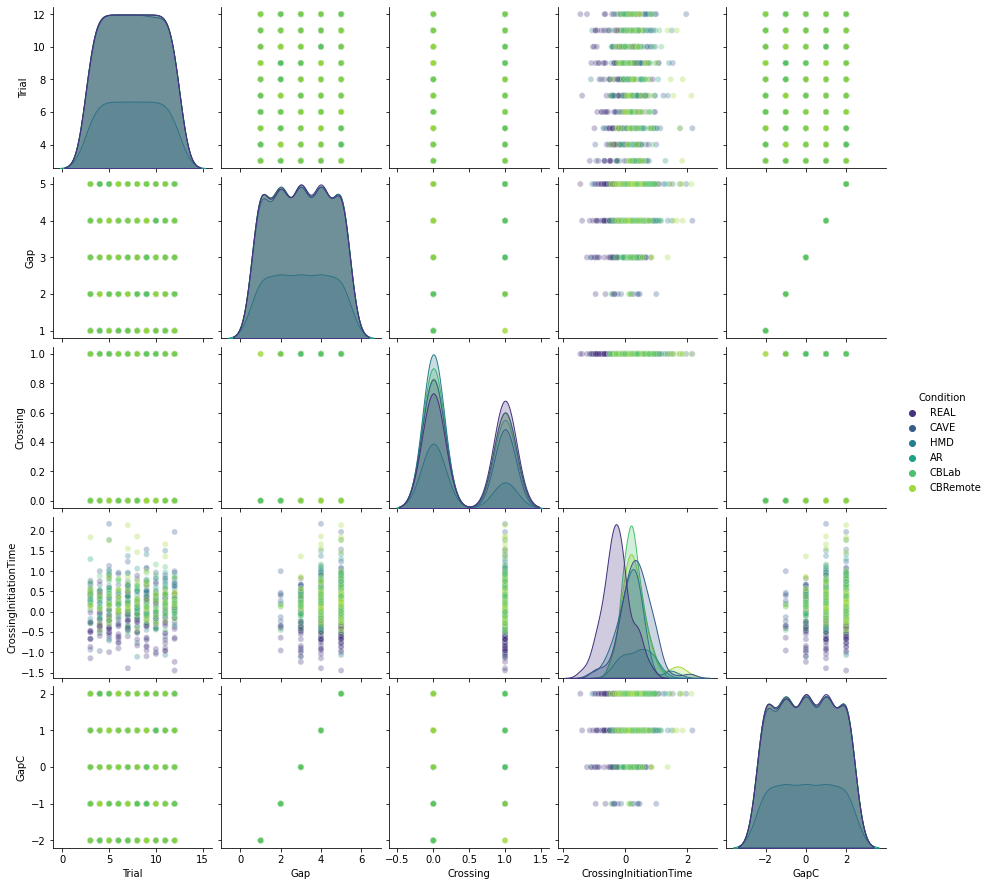

In [5]:
sns.pairplot(df, hue="Condition",plot_kws=dict(alpha=0.3));

## Gap Acceptance

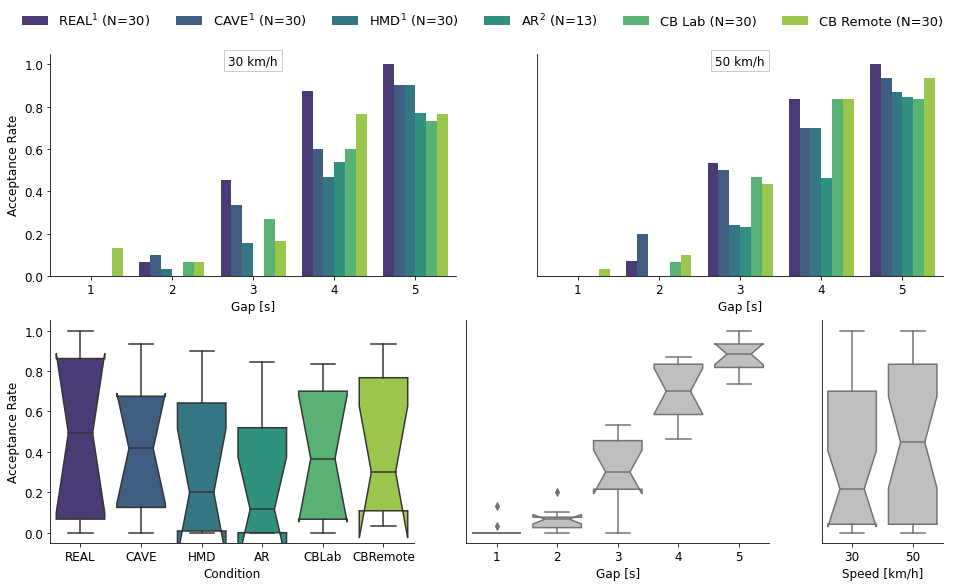

In [6]:
columns = ['Condition','Speed','Gap [s]','Acceptance Rate']
df_gap_acceptance = pd.DataFrame(columns = columns)
for Speed in [30,50]:
    for Condition in ['REAL','CAVE','HMD','AR','CBLab', 'CBRemote']:
        for Gap in range(1,6):
            df_gap_acceptance.loc[len(df_gap_acceptance)] = [Condition,Speed,Gap, df.loc[(df['Condition'] == Condition) & (df['Speed'] == Speed) & (df['Gap'] == Gap)]
                                                             .Crossing.value_counts(normalize=True,sort=False, dropna=False).get(1, 0)]


fig = plt.figure(figsize=(16,9))
plt.rcParams.update({'font.size': 12})
gs0 = gridspec.GridSpec(2, 1, figure=fig)
gs00 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs0[0])
ax1 = fig.add_subplot(gs00[0, 0])
ax2 = fig.add_subplot(gs00[0, 1])

gs01 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs0[1], width_ratios = [6,5,2])
ax3 = fig.add_subplot(gs01[0, 0])
ax4 = fig.add_subplot(gs01[0, 1])
ax5 = fig.add_subplot(gs01[0, 2])


sns.barplot(x='Gap [s]', y='Acceptance Rate', ax = ax1,hue='Condition',
            data=df_gap_acceptance.loc[df_gap_acceptance['Speed'] == 30]);
ax1.get_legend().remove()
ax1.text(2, 1, '30 km/h', horizontalalignment='center', bbox=dict(facecolor='white', alpha=0.2))

sns.barplot(x='Gap [s]', y='Acceptance Rate', ax = ax2,hue='Condition',
            data=df_gap_acceptance.loc[df_gap_acceptance['Speed'] == 50]);
ax2.get_legend().remove()
ax2.yaxis.set_visible(False)
ax2.text(2, 1, '50 km/h', horizontalalignment='center', bbox=dict(facecolor='white', alpha=0.2))

sns.boxplot(ax = ax3,x='Condition', y='Acceptance Rate', data=df_gap_acceptance);

sns.boxplot(ax = ax4,x='Gap [s]', y='Acceptance Rate', data=df_gap_acceptance, color = '#bfbfbf');
ax4.yaxis.set_visible(False)

sns.boxplot(ax = ax5,x='Speed', y='Acceptance Rate', data=df_gap_acceptance, color = '#bfbfbf');
ax5.yaxis.set_visible(False)
ax5.set_xlabel('Speed [km/h]')

plt.legend(bbox_to_anchor=(-2.8, 2.35), loc='center', prop={'size': 13},
           ncol=6,handles = ax1.get_legend_handles_labels()[0], 
           labels=['REAL$^{1}$ (N=30)', 'CAVE$^{1}$ (N=30)', 'HMD$^{1}$ (N=30)', 
                   'AR$^{2}$ (N=13)', 'CB Lab (N=30)', 'CB Remote (N=30)'])

sns.despine()

In [7]:
df_gap_acceptance.iloc[:,3] = pd.to_numeric(df_gap_acceptance.iloc[:,3], errors='coerce')
df_gap_acceptance.groupby('Condition')['Acceptance Rate'].mean()

Condition
AR          0.284615
CAVE        0.426667
CBLab       0.386667
CBRemote    0.423333
HMD         0.336430
REAL        0.482488
Name: Acceptance Rate, dtype: float64

## Crossing Initiation Time

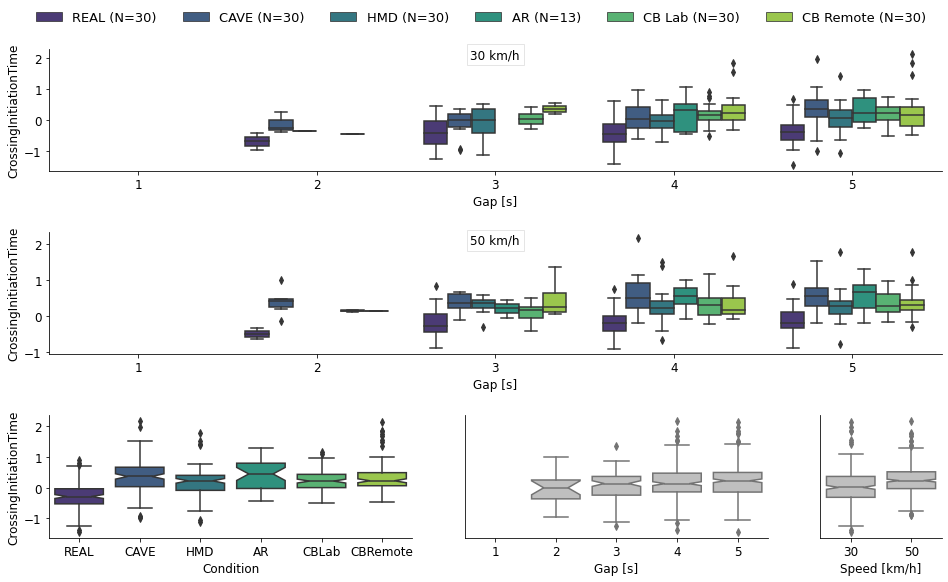

In [8]:
fig = plt.figure(figsize=(16,9))
plt.rcParams.update({'font.size': 12})
gs0 = gridspec.GridSpec(3, 1, figure=fig,hspace=0.5)
gs00 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs0[0])
ax1 = fig.add_subplot(gs00[0, 0])

gs01 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs0[1])
ax2 = fig.add_subplot(gs01[0, 0])

gs02 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs0[2], width_ratios = [6,5,2])
ax3 = fig.add_subplot(gs02[0, 0])
ax4 = fig.add_subplot(gs02[0, 1])
ax5 = fig.add_subplot(gs02[0, 2])

sns.boxplot(x='Gap', y='CrossingInitiationTime', ax = ax1,hue='Condition',
            data=df.loc[df['Speed'] == 30],notch = False);
ax1.set_xlabel('Gap [s]')
ax1.get_legend().remove()
ax1.text(2, 2, '30 km/h', horizontalalignment='center', bbox=dict(facecolor='white', alpha=0.1))
sns.boxplot(x='Gap', y='CrossingInitiationTime', ax = ax2,hue='Condition',
            data=df.loc[df['Speed'] == 50],notch = False);

ax2.get_legend().remove()
ax2.text(2, 2, '50 km/h', horizontalalignment='center', bbox=dict(facecolor='white', alpha=0.1))
#ax2.yaxis.set_visible(False)
ax2.set_xlabel('Gap [s]')

sns.boxplot(ax = ax3,x='Condition', y='CrossingInitiationTime', data=df, order=['REAL','CAVE','HMD','AR','CBLab', 'CBRemote']);

sns.boxplot(ax = ax4,x='Gap', y='CrossingInitiationTime', data=df, color = '#bfbfbf');
ax4.yaxis.set_visible(False)
ax4.set_xlabel('Gap [s]')

sns.boxplot(ax = ax5,x='Speed', y='CrossingInitiationTime', data=df, color = '#bfbfbf');
ax5.yaxis.set_visible(False)
ax5.set_xlabel('Speed [km/h]')

plt.legend(bbox_to_anchor=(-2.8, 4.25), loc='center', prop={'size': 13},
           ncol=6,handles = ax1.get_legend_handles_labels()[0], 
           labels=['REAL (N=30)', 'CAVE (N=30)', 'HMD (N=30)', 
                   'AR (N=13)', 'CB Lab (N=30)', 'CB Remote (N=30)'])

sns.despine()

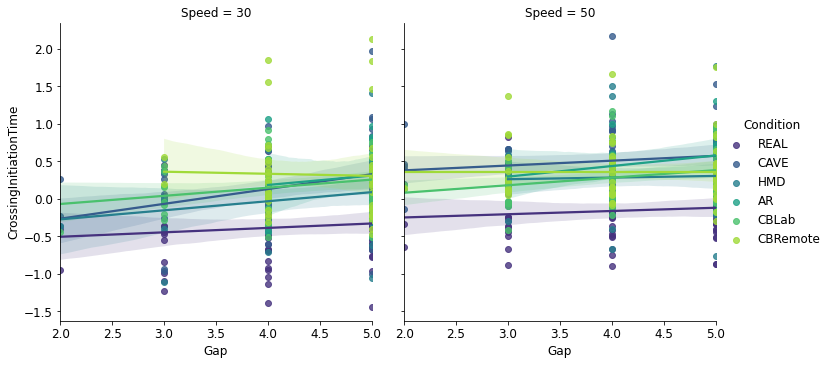

In [9]:
g = sns.lmplot(x = 'Gap', y = 'CrossingInitiationTime',col = 'Speed', hue = 'Condition', 
           data = df.loc[df['Gap'] != 1], ci=95);

## Subjective Data

Q1: How safe would it have been to cross the street?

Q2: How likely would a collision have been?

Q3: How dangerous would a collision have been?

Q4: How similar to real world traffic was your behavior in cases when you crossed the street?

Q5: How similar to real world traffic was your behavior in cases when you did not cross the street?

Q6: Compared to usual, my choices were safe / unsafe

Q7: Compared to usual, deciding to cross the street was easy / difficult

Q8: Compared to usual, making a decision took longer / shorter

In [10]:
df_subjectives = pd.read_csv("questionnaires_all.csv", encoding="cp1252")
df_subjectives = df_subjectives.astype({"Condition": 'category',"ID": 'category'})
df_subjectives['Condition'] = df_subjectives['Condition'].cat.reorder_categories(['REAL','CAVE','HMD','AR','CBLab','CBRemote'], ordered=True)
df_subjectives

VP Condition      Q4                                                4aY  \
0     1     CBLab  11.726                           reales Verhalten möglich   
1     2  CBRemote   9.915  es würde auch vom augenkontakt mit dem Fahrer(...   
2     3  CBRemote   9.448  wenn danach kein Auto mehr gekommen wäre, hätt...   
3     4     CBLab   7.927                       etwas risikofreudiger bei VR   
4     5  CBRemote   9.202  mir fiel zu Beginn dir Abschötzung schwer,  da...   
..   ..       ...     ...                                                ...   
165  59       HMD  12.200  in VR i felt almost like in real world an di b...   
166  60       HMD   4.000  je sius quelque'un de tres prudent en situatio...   
167  61       HMD  11.900  dans la vie relle j'etude de la meme facon que...   
168  62       HMD   4.500  Comme? dans la vie reele je traverse la rue me...   
169  63       HMD  10.200                                                NaN   

         Q5                                                4bY  Age  EyeLevel  \
0    10.757                           reales Verhalten möglich   30     194.0   
1    12.451                        Wäre mir zu riskant gewesen   23     175.0   
2    12.992                                      zu gefährlich   24     183.0   
3    11.796                  so würde ich es auch sonst machen   26     170.0   
4     9.202                                               s.o.   30     163.0   
..      ...                                                ...  ...       ...   
165  10.300  I believe that in the real world i am taking i...   27       NaN   
166  13.000           je suis tres prudent en situation reelle   23       NaN   
167  11.400  les voitures, dans ces cas la, allaient bien t...   29       NaN   
168   1.800                                                NaN   26       NaN   
169  10.400                                                NaN   23       NaN   

     Gender   Q7  ...                               Sonstige Anmerkungen   Q3  \
0      male  1.0  ...                                                NaN  3.0   
1    female  1.0  ...  bei mir gabs in der brille einen leichten "rec...  2.0   
2    female  1.0  ...                                                NaN  4.0   
3    female  1.0  ...                                                NaN  3.0   
4    female  1.0  ...                                                NaN  2.0   
..      ...  ...  ...                                                ...  ...   
165       m -1.0  ...  I would use the audio signals to learn about t...  3.0   
166       m  1.0  ...                                                NaN  3.0   
167       f  0.0  ...                                                NaN  3.0   
168       m  0.0  ...                         tres bonne experimentation  4.0   
169       m  1.0  ...                                                NaN  3.0   

     Q1 Q2                     Date  CIT Warnings  Button Warnings  \
0     3  2  2020-10-06T15:39:26:607           0.0              1.0   
1     3  4  2020-12-05T13:30:16:604           1.0              0.0   
2     3  2  2020-12-17T11:15:45:207           2.0              1.0   
3     3  1  2020-10-05T16:04:10:076           0.0              0.0   
4     1  1  2020-11-04T13:31:47:671           0.0              0.0   
..   .. ..                      ...           ...              ...   
165   3  2                      NaN           NaN              NaN   
166   3  3                      NaN           NaN              NaN   
167   3  2                      NaN           NaN              NaN   
168   4  3                      NaN           NaN              NaN   
169   3  2                      NaN           NaN              NaN   

     Button Deletes Resolution          ID  
0               0.0      0.922     1_CBLab  
1               0.0      2.333  2_CBRemote  
2               0.0      2.074  3_CBRemote  
3               0.0      1.349     4_CBLab  
4               0.0      1.349  

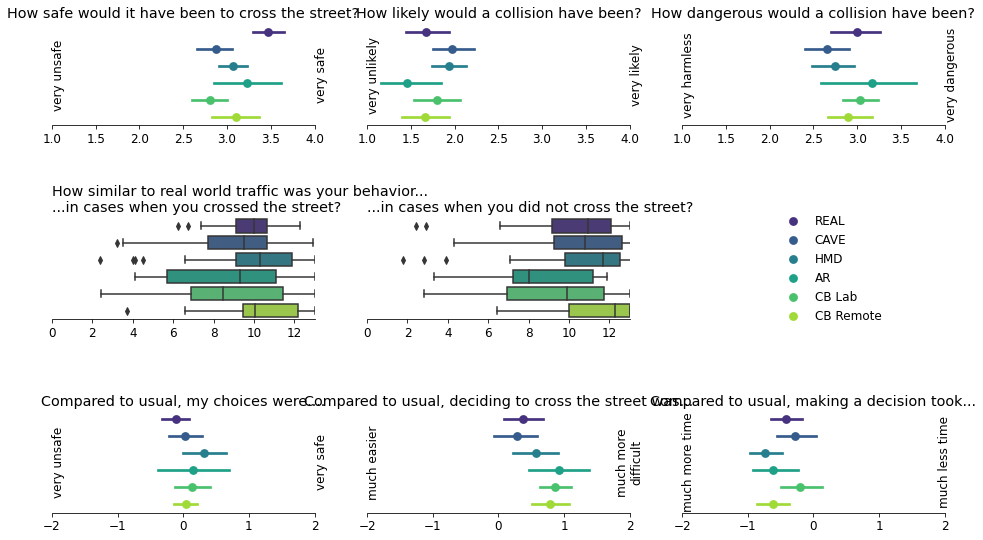

In [11]:
order = ['REAL','CAVE','HMD','AR','CBLab', 'CBRemote']
fig = plt.figure(figsize=(16, 9))

ax1 = plt.subplot(3, 3, 1)
ax1.set_title("How safe would it have been to cross the street?")
sns.pointplot(y='Condition', x='Q1',join=False, data = df_subjectives,
             hue='Condition',hue_order=order,order=order, ax=ax1);
ax1.text(0, 0.5, "very unsafe",transform=ax1.transAxes, rotation = 90,verticalalignment='center')
ax1.text(1, 0.5, "very safe",transform=ax1.transAxes, rotation = 90,verticalalignment='center')
ax1.set(xlim=(1, 4))

ax2 = plt.subplot(3, 3, 2)
ax2.set_title("How likely would a collision have been?")
sns.pointplot(y='Condition', x='Q2',join=False, data = df_subjectives,
             hue='Condition',hue_order=order,order=order, ax=ax2);
ax2.text(0, 0.5, "very unlikely",transform=ax2.transAxes, rotation = 90,verticalalignment='center')
ax2.text(1, 0.5, "very likely",transform=ax2.transAxes, rotation = 90,verticalalignment='center')
ax2.set(xlim=(1, 4))

ax3 = plt.subplot(3, 3, 3)
ax3.set_title("How dangerous would a collision have been?")
sns.pointplot(y='Condition', x='Q3',join=False, data = df_subjectives,
             hue='Condition',hue_order=order,order=order, ax=ax3);
ax3.text(0, 0.5, "very harmless",transform=ax3.transAxes, rotation = 90,verticalalignment='center')
ax3.text(1, 0.5, "very dangerous",transform=ax3.transAxes, rotation = 90,verticalalignment='center')
ax3.set(xlim=(1, 4))


ax4 = plt.subplot(3, 3, 4)
ax4.set_title("How similar to real world traffic was your behavior... \n...in cases when you crossed the street?" , loc='left')
sns.boxplot(y="Condition", x='Q4', orient = "h", notch = False,
                data = df_subjectives, hue_order=order, order=order);
ax4.set(xlim=(0, 13))
    
ax5 = plt.subplot(3, 3, 5)
ax5.set_title("\n...in cases when you did not cross the street?", loc='left')
sns.boxplot(y="Condition", x='Q5', orient = "h", notch = False,
                data = df_subjectives, hue_order=order, order=order);
ax5.set(xlim=(0, 13))

ax6 = plt.subplot(3, 3, 7)
ax6.set_title("Compared to usual, my choices were....")
sns.pointplot(y='Condition', x='Q6',join=False, data = df_subjectives,
             hue='Condition',hue_order=order,order=order, ax=ax6);
ax6.text(0, 0.5, "very unsafe",transform=ax6.transAxes, rotation = 90,verticalalignment='center')
ax6.text(1, 0.5, "very safe",transform=ax6.transAxes, rotation = 90,verticalalignment='center')
ax6.set(xlim=(-2, 2))
    
ax7 = plt.subplot(3, 3, 8)
ax7.set_title("Compared to usual, deciding to cross the street was...")
sns.pointplot(y='Condition', x='Q7',join=False, data = df_subjectives,
             hue='Condition',hue_order=order,order=order, ax=ax7);
ax7.text(0, 0.5, "much easier",transform=ax7.transAxes, rotation = 90,verticalalignment='center')
ax7.text(1, 0.5, "much more\ndifficult",transform=ax7.transAxes, rotation = 90,verticalalignment='center',horizontalalignment='center')
ax7.set(xlim=(-2, 2))
    
ax8 = plt.subplot(3, 3, 9)
ax8.set_title("Compared to usual, making a decision took...")
sns.pointplot(y='Condition', x='Q8',join=False, data = df_subjectives,
             hue='Condition',hue_order=order,order=order, ax=ax8);
ax8.text(0, 0.5, "much more time",transform=ax8.transAxes, rotation = 90,verticalalignment='center')
ax8.text(1, 0.5, "much less time",transform=ax8.transAxes, rotation = 90,verticalalignment='center',horizontalalignment='center')
ax8.set(xlim=(-2, 2))


axes = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8]
for ax in axes:
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_yticks([])
    ax.spines['left'].set_color('white')
    ax.legend([],[], frameon=False)

ax5.legend(bbox_to_anchor=(2, 0.5), loc='right',prop={'size': 12},
           handles = ax1.get_legend_handles_labels()[0],ncol=1, 
           labels=['REAL', 'CAVE', 'HMD', 'AR', 'CB Lab ', 'CB Remote']);

fig.subplots_adjust(hspace=0.9, wspace=0.2)
sns.despine()

# Bayes Analysis

## Gap Acceptance

### Models

In [12]:
crossing_model = bmb.Model(df)
crossing_fitted = crossing_model.fit("Crossing ~ 0 + Condition + Speed + GapC + (1|ID))",
                                     categorical=["Condition","Speed"],
                                     family="bernoulli", draws=4000, target_accept=0.85, random_seed=RANDOM_SEED)
az.summary(crossing_fitted,var_names=["~ID"], filter_vars="regex")
#https://mc-stan.org/misc/warnings.html
#We recommend requiring that the bulk-ESS is greater than 100 times the number of chains. 
#We recommend running at least four chains by default and only using the sample if R-hat is less than 1.01

Modeling the probability that Crossing==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [1|ID_offset, 1|ID_sigma, GapC, Speed, Condition]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 115 seconds.


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Condition[0] -0.548  0.362  -1.263    0.099      0.003    0.002   11803.0   
Condition[1] -1.174  0.368  -1.868   -0.496      0.003    0.002   11754.0   
Condition[2] -2.188  0.379  -2.887   -1.459      0.003    0.002   12744.0   
Condition[3] -2.764  0.557  -3.816   -1.726      0.005    0.003   13730.0   
Condition[4] -1.622  0.374  -2.303   -0.899      0.003    0.002   12394.0   
Condition[5] -1.220  0.366  -1.941   -0.558      0.003    0.002   12411.0   
Speed         0.726  0.170   0.403    1.040      0.001    0.001   24988.0   
GapC          2.200  0.121   1.974    2.426      0.001    0.001   15227.0   

              ess_tail  r_hat  
Condition[0]   12112.0    1.0  
Condition[1]   10768.0    1.0  
Condition[2]   11793.0    1.0  
Condition[3]   12773.0    1.0  
Condition[4]   11573.0    1.0  
Condition[5]   11070.0    1.0  
Speed          11980.0    1.0  
GapC           11707.0    1.0

In [13]:
crossing_model_interactions = bmb.Model(df)
crossing_fitted_interactions = crossing_model.fit("Crossing ~ 0 + Condition + Speed + GapC + Condition:Speed + Condition:GapC + (1|ID))",
                                     categorical=["Condition","Speed"],
                                     family="bernoulli", draws=4000, target_accept=0.85, random_seed=RANDOM_SEED)
az.summary(crossing_fitted,var_names=["~ID"], filter_vars="regex")

Modeling the probability that Crossing==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [1|ID_offset, 1|ID_sigma, Condition:GapC, Condition:Speed, GapC, Speed, Condition]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 133 seconds.
The number of effective samples is smaller than 25% for some parameters.


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Condition[0] -0.548  0.362  -1.263    0.099      0.003    0.002   11803.0   
Condition[1] -1.174  0.368  -1.868   -0.496      0.003    0.002   11754.0   
Condition[2] -2.188  0.379  -2.887   -1.459      0.003    0.002   12744.0   
Condition[3] -2.764  0.557  -3.816   -1.726      0.005    0.003   13730.0   
Condition[4] -1.622  0.374  -2.303   -0.899      0.003    0.002   12394.0   
Condition[5] -1.220  0.366  -1.941   -0.558      0.003    0.002   12411.0   
Speed         0.726  0.170   0.403    1.040      0.001    0.001   24988.0   
GapC          2.200  0.121   1.974    2.426      0.001    0.001   15227.0   

              ess_tail  r_hat  
Condition[0]   12112.0    1.0  
Condition[1]   10768.0    1.0  
Condition[2]   11793.0    1.0  
Condition[3]   12773.0    1.0  
Condition[4]   11573.0    1.0  
Condition[5]   11070.0    1.0  
Speed          11980.0    1.0  
GapC           11707.0    1.0

In [14]:
#https://mc-stan.org/misc/warnings.html
#We recommend requiring that the bulk-ESS is greater than 100 times the number of chains. 
#We recommend running at least four chains by default and only using the sample if R-hat is less than 1.01

In [15]:
crossing_model_slope_gap = bmb.Model(df)
crossing_fitted_slope_gap = crossing_model_slope_gap.fit("Crossing ~ 0 + Condition + Speed + GapC + (GapC|ID))",
                                     categorical=["Condition","Speed"],
                                     family="bernoulli", draws=4000, target_accept=0.85, random_seed=RANDOM_SEED)
az.summary(crossing_fitted,var_names=["~ID"], filter_vars="regex")

Modeling the probability that Crossing==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [GapC|ID_offset, GapC|ID_sigma, 1|ID_offset, 1|ID_sigma, GapC, Speed, Condition]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 106 seconds.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Condition[0] -0.548  0.362  -1.263    0.099      0.003    0.002   11803.0   
Condition[1] -1.174  0.368  -1.868   -0.496      0.003    0.002   11754.0   
Condition[2] -2.188  0.379  -2.887   -1.459      0.003    0.002   12744.0   
Condition[3] -2.764  0.557  -3.816   -1.726      0.005    0.003   13730.0   
Condition[4] -1.622  0.374  -2.303   -0.899      0.003    0.002   12394.0   
Condition[5] -1.220  0.366  -1.941   -0.558      0.003    0.002   12411.0   
Speed         0.726  0.170   0.403    1.040      0.001    0.001   24988.0   
GapC          2.200  0.121   1.974    2.426      0.001    0.001   15227.0   

              ess_tail  r_hat  
Condition[0]   12112.0    1.0  
Condition[1]   10768.0    1.0  
Condition[2]   11793.0    1.0  
Condition[3]   12773.0    1.0  
Condition[4]   11573.0    1.0  
Condition[5]   11070.0    1.0  
Speed          11980.0    1.0  
GapC           11707.0    1.0

In [16]:
crossing_model_slope_speed = bmb.Model(df)
crossing_fitted_slope_speed = crossing_model_slope_speed.fit("Crossing ~ 0 + Condition + Speed + GapC + (Speed|ID))",
                                     categorical=["Condition","Speed"],
                                     family="bernoulli", draws=4000, target_accept=0.85, random_seed=RANDOM_SEED)
az.summary(crossing_fitted,var_names=["~ID"], filter_vars="regex")

Modeling the probability that Crossing==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Speed[50]|ID_offset, Speed[50]|ID_sigma, 1|ID_offset, 1|ID_sigma, GapC, Speed, Condition]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 110 seconds.
There were 112 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Condition[0] -0.548  0.362  -1.263    0.099      0.003    0.002   11803.0   
Condition[1] -1.174  0.368  -1.868   -0.496      0.003    0.002   11754.0   
Condition[2] -2.188  0.379  -2.887   -1.459      0.003    0.002   12744.0   
Condition[3] -2.764  0.557  -3.816   -1.726      0.005    0.003   13730.0   
Condition[4] -1.622  0.374  -2.303   -0.899      0.003    0.002   12394.0   
Condition[5] -1.220  0.366  -1.941   -0.558      0.003    0.002   12411.0   
Speed         0.726  0.170   0.403    1.040      0.001    0.001   24988.0   
GapC          2.200  0.121   1.974    2.426      0.001    0.001   15227.0   

              ess_tail  r_hat  
Condition[0]   12112.0    1.0  
Condition[1]   10768.0    1.0  
Condition[2]   11793.0    1.0  
Condition[3]   12773.0    1.0  
Condition[4]   11573.0    1.0  
Condition[5]   11070.0    1.0  
Speed          11980.0    1.0  
GapC           11707.0    1.0

In [17]:
compare_dict = {"No Interactions": crossing_fitted,
                "Interactions": crossing_fitted_interactions,
                "Random Slope Gap": crossing_fitted_slope_gap,
                "Random Slope Speed":crossing_fitted_slope_speed}
az.compare(compare_dict, ic="loo")

C:\Users\phili\AppData\Roaming\Python\Python38\site-packages\arviz\stats\stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(


rank         loo       p_loo     d_loo        weight  \
No Interactions        0 -526.149798  110.571432  0.000000  2.859675e-01   
Random Slope Gap       1 -526.167904  134.712054  0.018106  3.334991e-01   
Random Slope Speed     2 -526.793932  115.448118  0.644133  1.123484e-15   
Interactions           3 -527.292298  126.167470  1.142500  3.805334e-01   

                           se       dse  warning loo_scale  
No Interactions     23.609587  0.000000    False       log  
Random Slope Gap    23.459271  3.352049    False       log  
Random Slope Speed  23.668820  0.441576    False       log  
Interactions        23.752406  4.576740    False       log

In [18]:
crossing_model = crossing_model
crossing_fitted = crossing_fitted

### Diagnostics

#### Priors

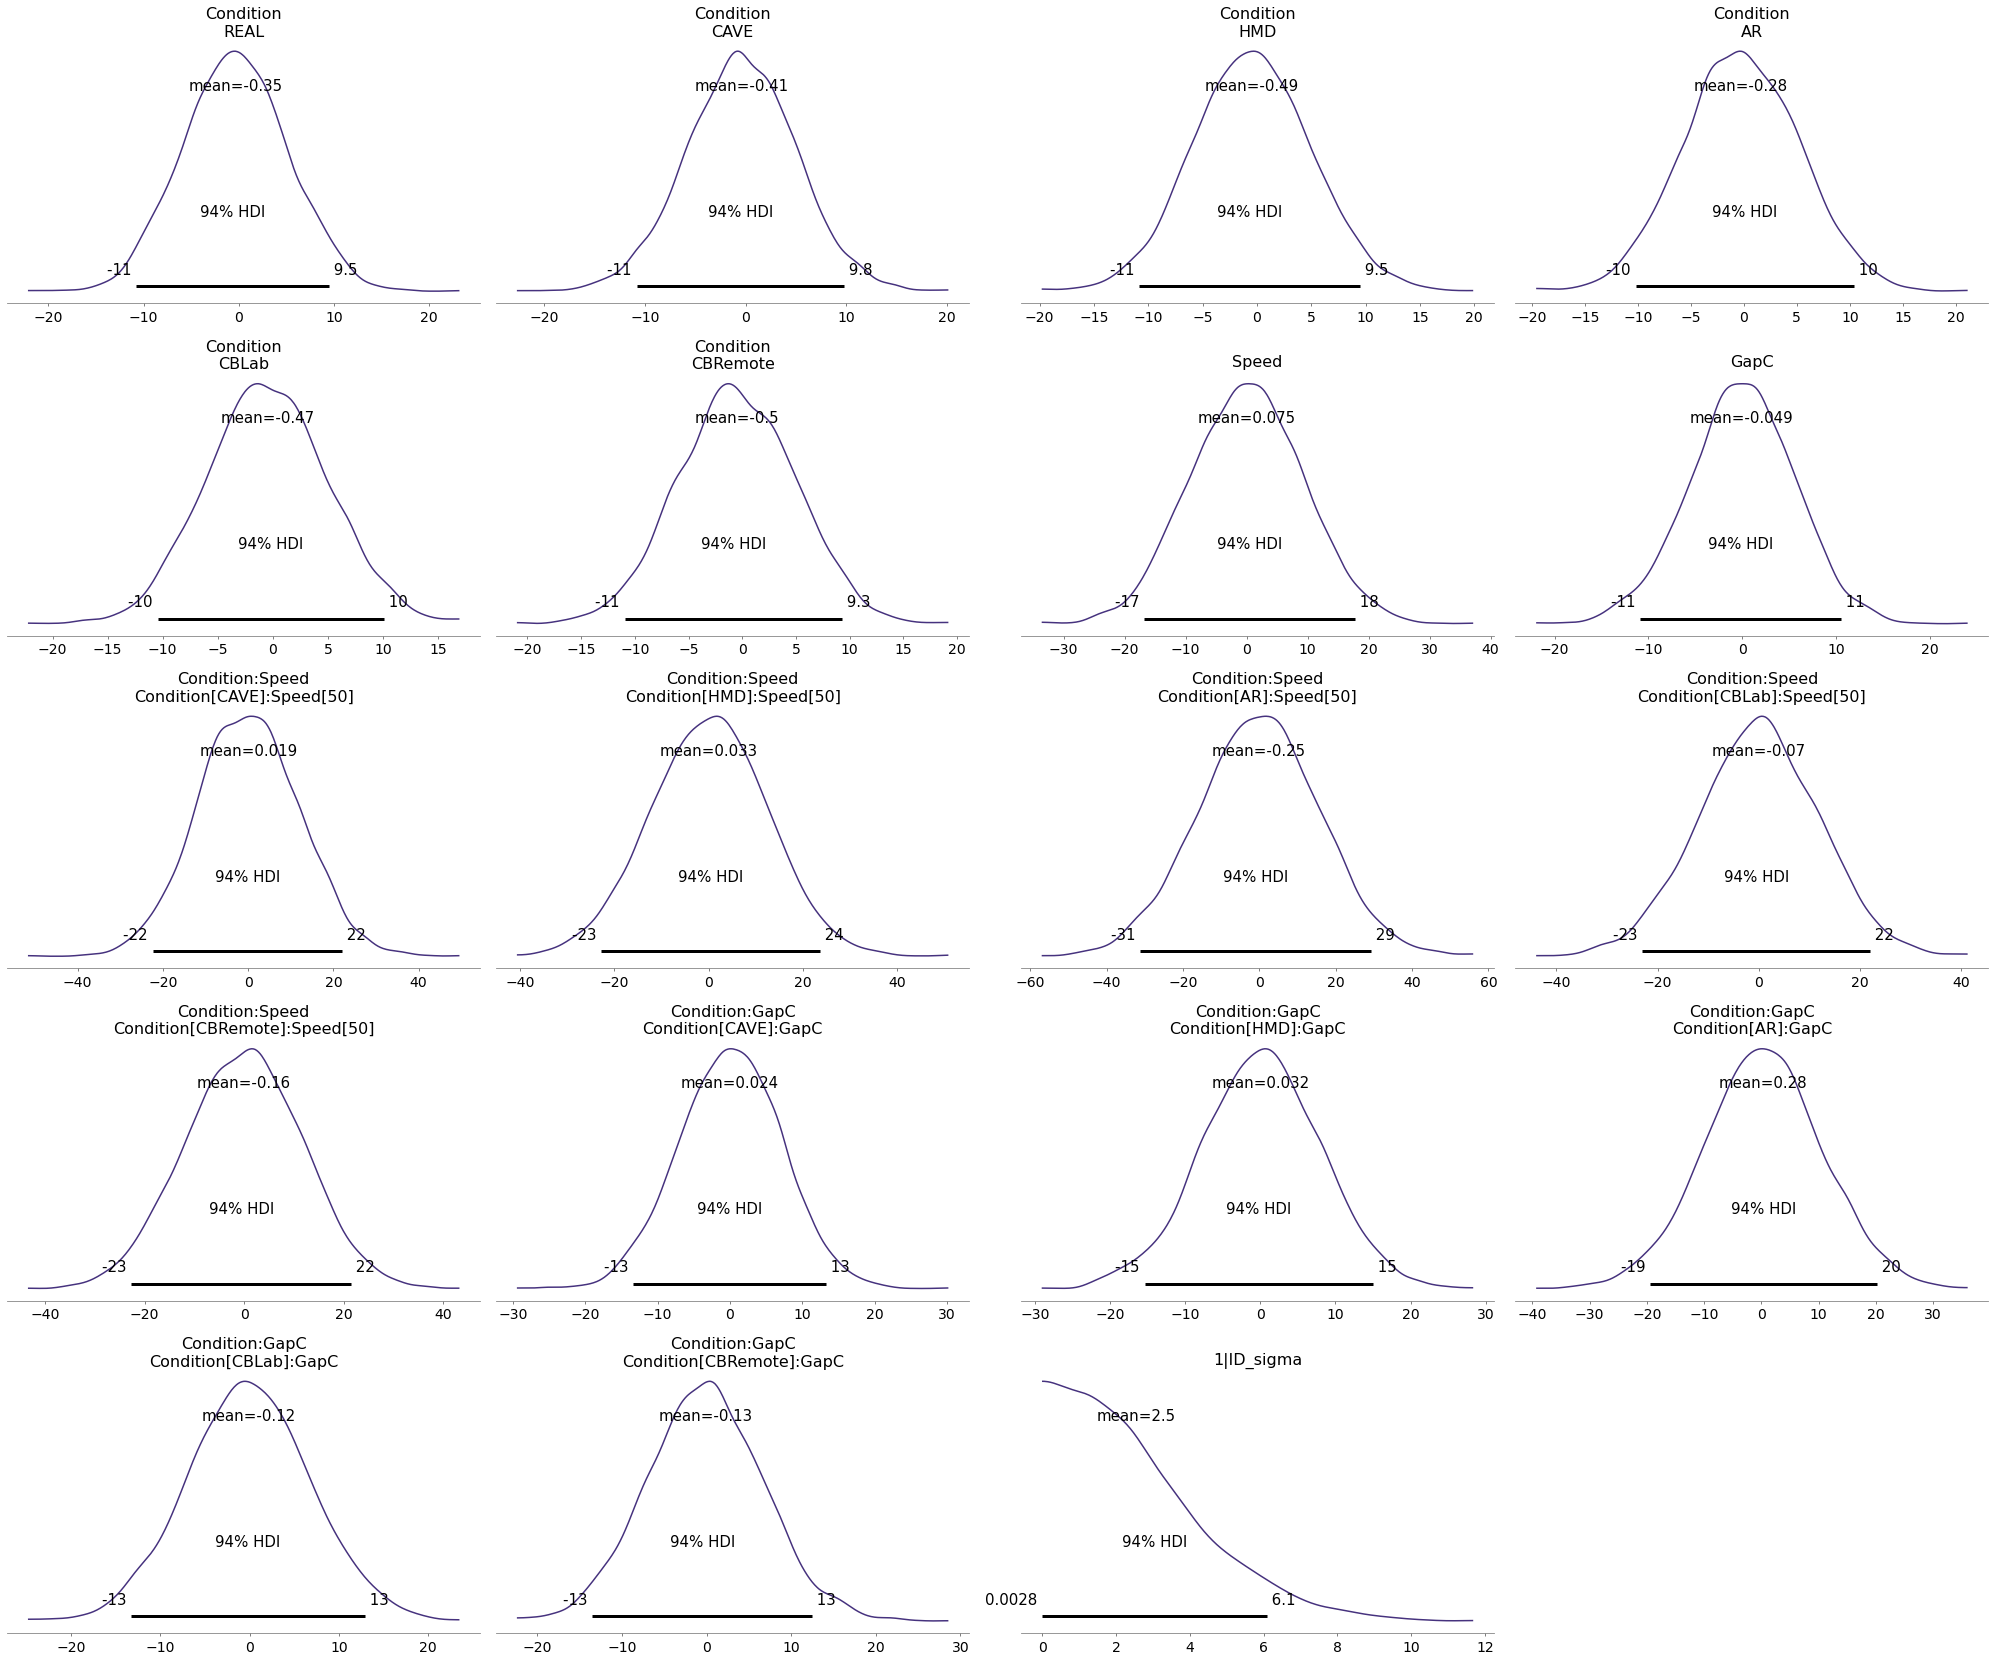

In [19]:
crossing_model.plot_priors();

In [20]:
{x.name: x.prior.args for x in crossing_model.terms.values()}

{'Condition': {'mu': array(-0.39830395), 'sigma': array(5.49822353)},
 'Speed': {'mu': array(0), 'sigma': array(9.14696152)},
 'GapC': {'mu': array(0), 'sigma': array(5.64675871)},
 'Condition:Speed': {'mu': array([0, 0, 0, 0, 0]),
  'sigma': array([11.85749931, 12.48123242, 15.98617579, 11.88215851, 11.72829299])},
 'Condition:GapC': {'mu': array([0, 0, 0, 0, 0]),
  'sigma': array([ 6.97426929,  7.95107201, 10.351053  ,  6.96025037,  6.81694419])},
 '1|ID': {'mu': array(0), 'sigma': HalfNormal(sigma: 3.17440084)}}

#### Fitting

C:\Users\phili\AppData\Roaming\Python\Python38\site-packages\pymc3\sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


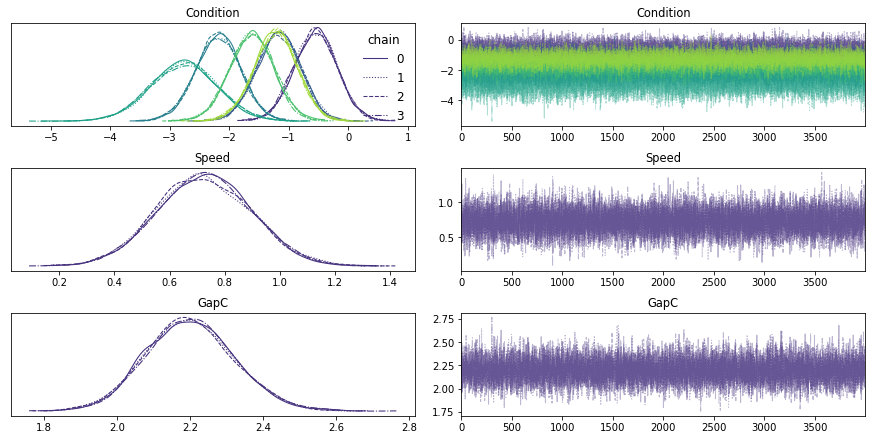

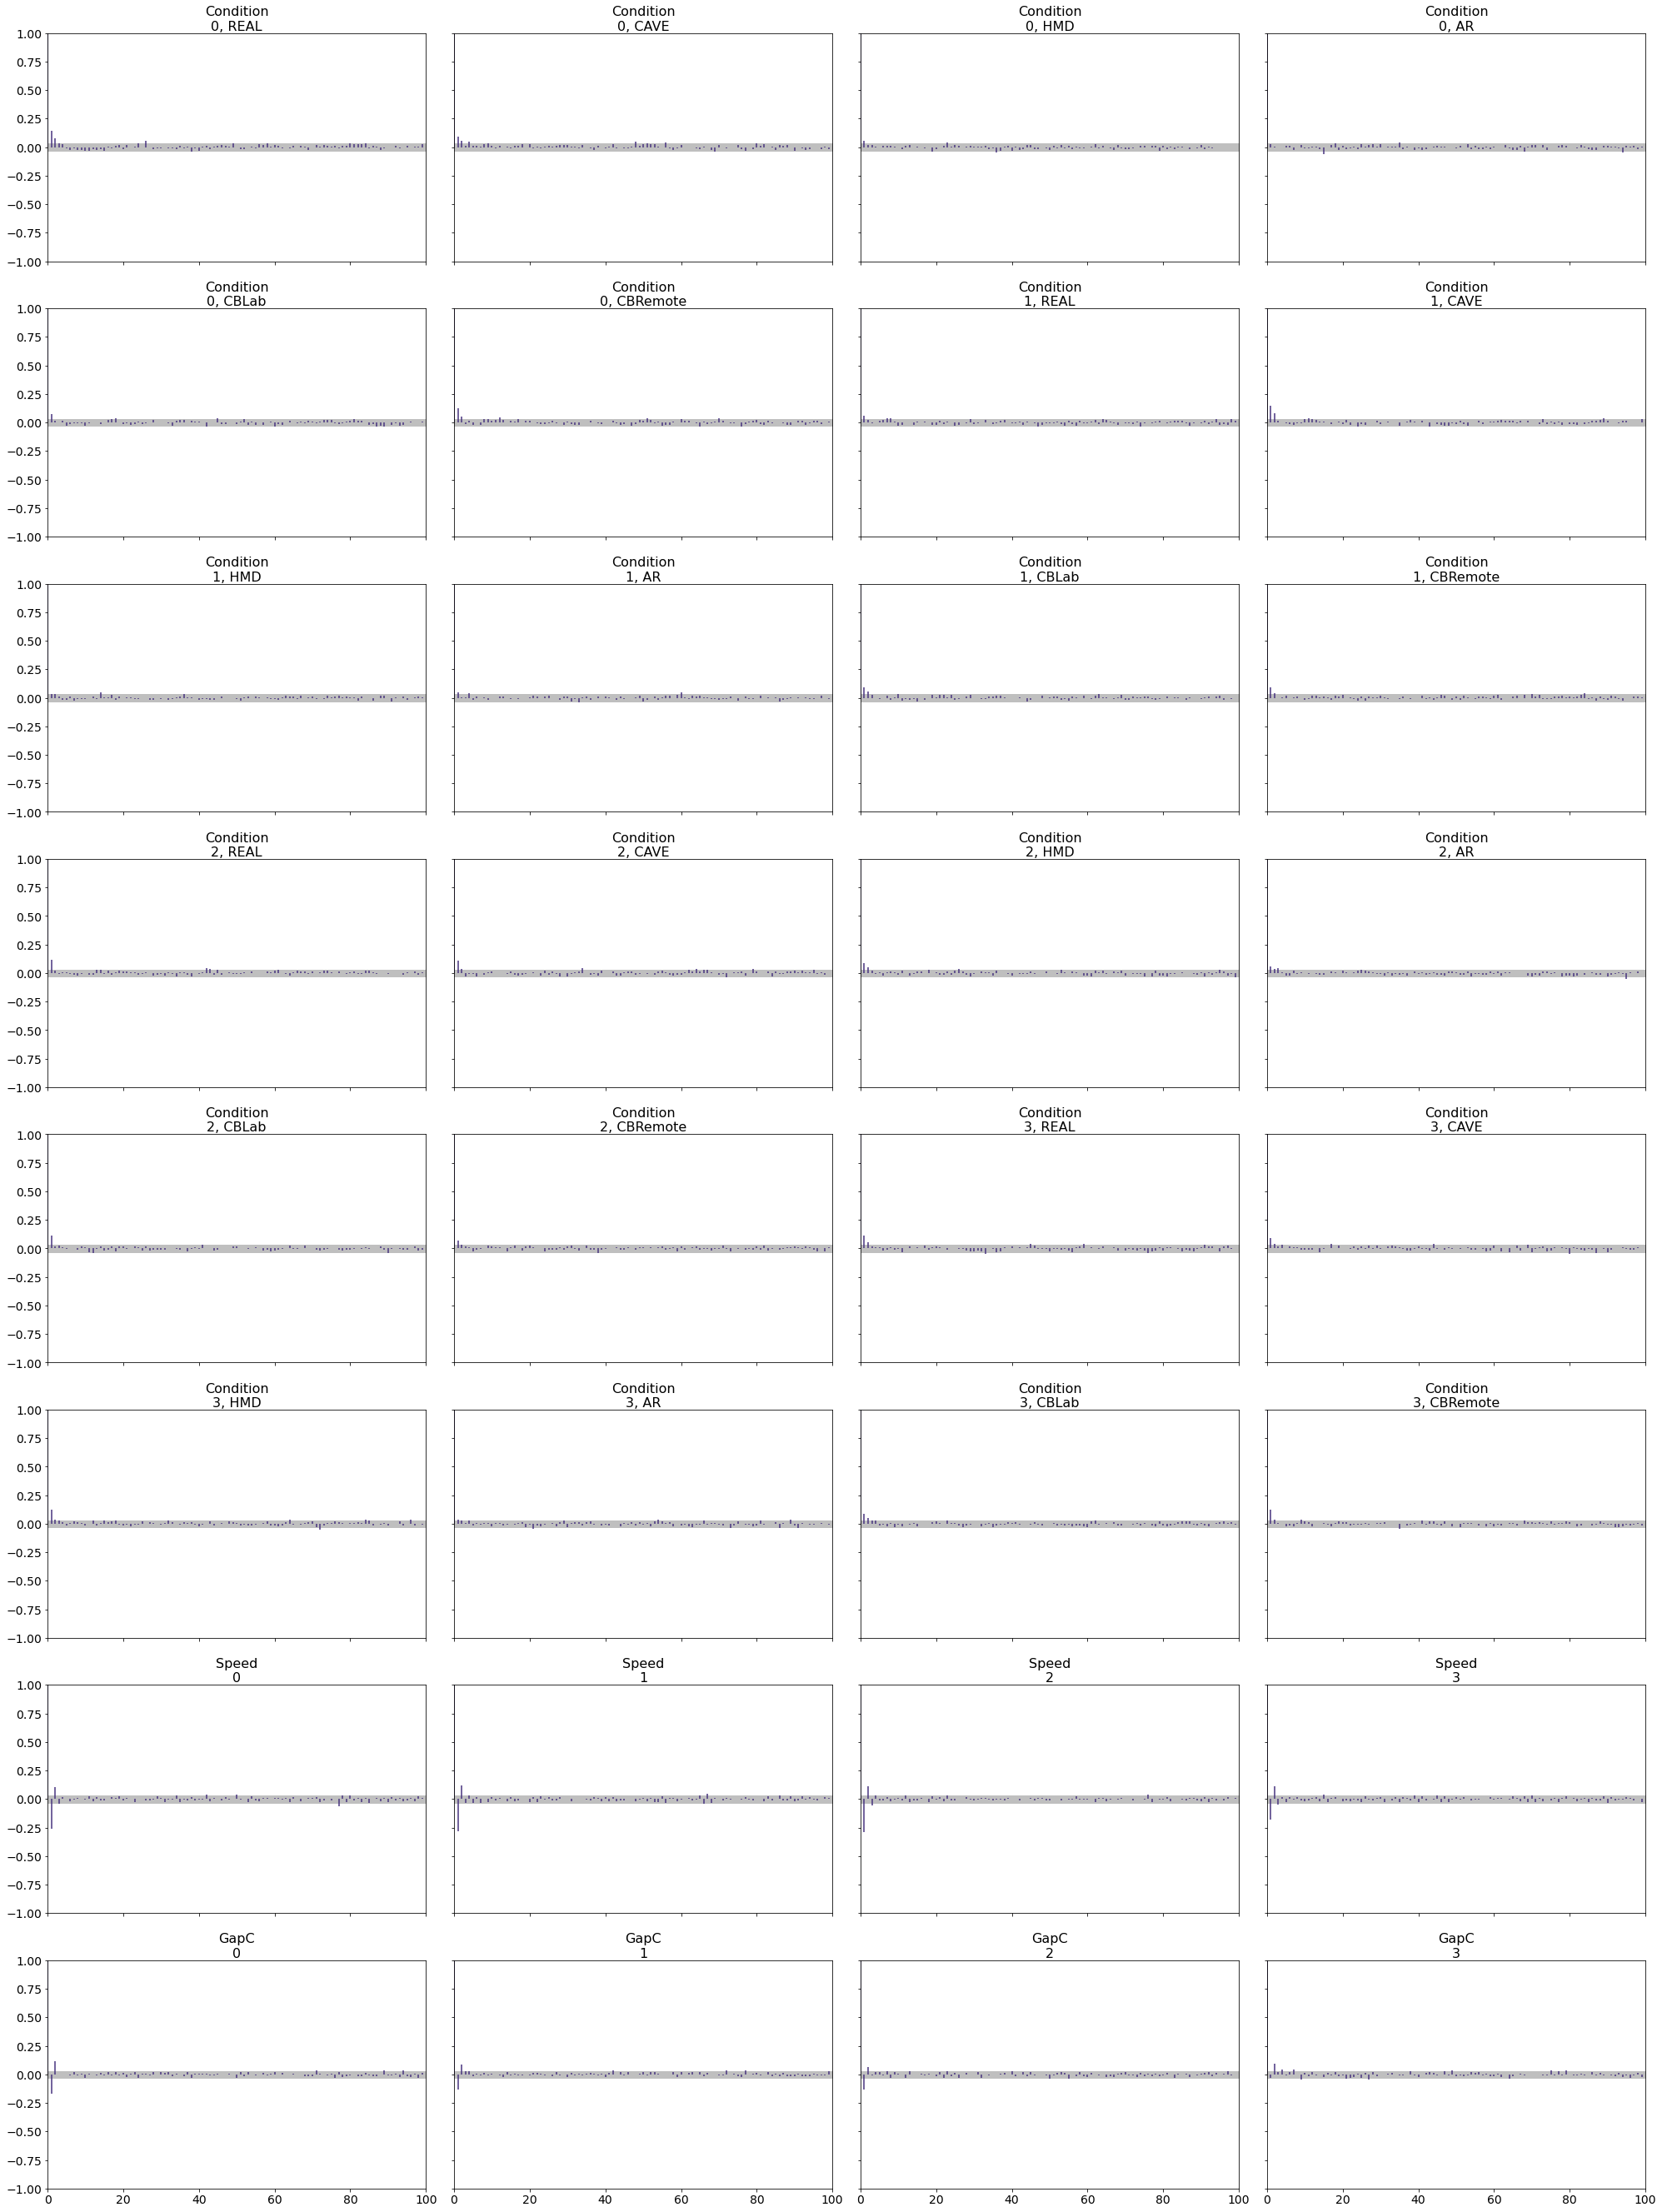

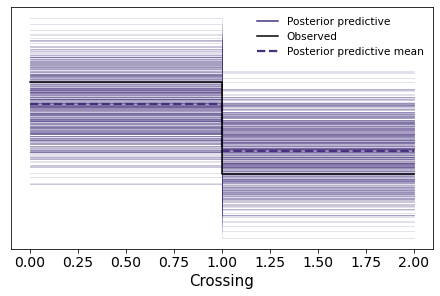

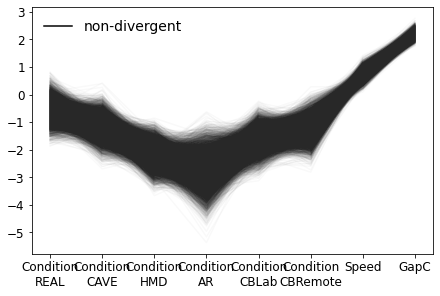

In [21]:
crossing_model.posterior_predictive(crossing_fitted, random_seed=RANDOM_SEED)

az.plot_trace(crossing_fitted,var_names=["~ID"], filter_vars="regex",legend=True, compact=True);
az.plot_autocorr(crossing_fitted,var_names=["~ID"], filter_vars="regex", combined = False);
az.plot_ppc(crossing_fitted);
az.plot_parallel(crossing_fitted,var_names=["~ID"], filter_vars="regex", legend = True);

### Inference

#### Posteriors

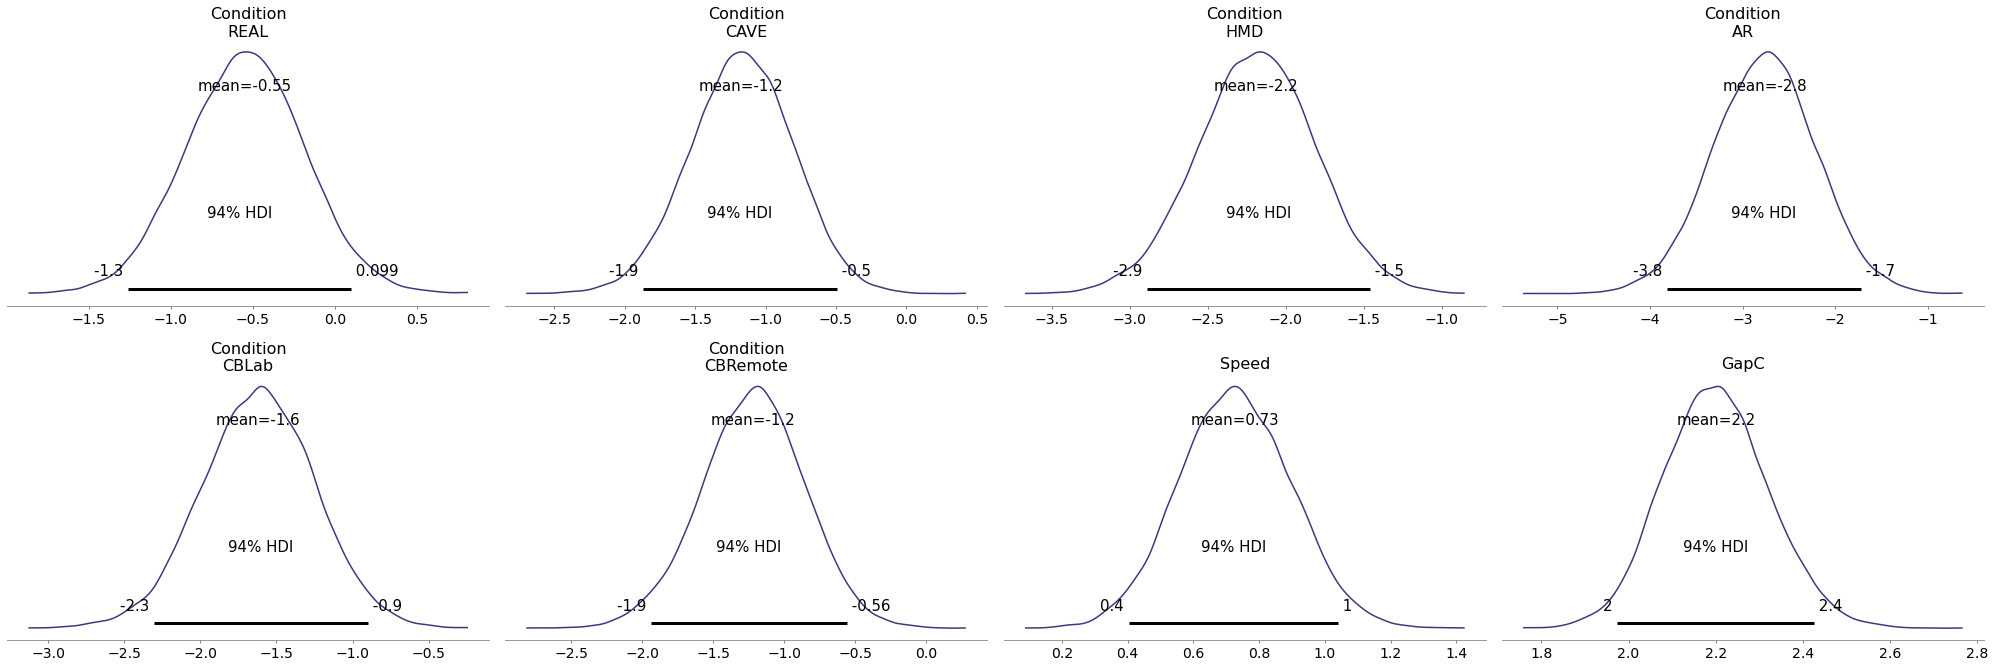

In [22]:
az.plot_posterior(crossing_fitted,var_names=["~ID"], filter_vars="regex");

#### Differences

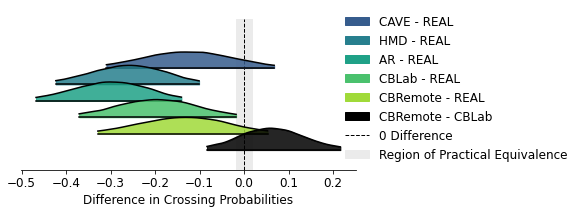

In [23]:
Conditions = ['REAL','CAVE','HMD','AR','CBLab','CBRemote']
REAL, CAVE, HMD, AR, CBLab, CBRemote = [crossing_fitted.posterior['Condition'][:,:,x].values for x in [0,1,2,3,4,5]]
pREAL, pCAVE, pHMD, pAR, pCBLab, pCBRemote = [plogis(crossing_fitted.posterior['Condition'][:,:,x].values) for x in [0,1,2,3,4,5]]
crossing_std = df.groupby('ID')['Crossing'].mean().std()


fig, ax = plt.subplots(figsize=(6, 3))
colors = sns.color_palette(palette = 'viridis')
colors.append('#000000')

ax.vlines(0,-10,18,'black', 'dashed', zorder=-10,lw=1)
az.plot_forest([pCAVE - pREAL,pHMD - pREAL,pAR - pREAL,pCBLab - pREAL,pCBRemote - pREAL, pCBRemote - pCBLab],
                model_names = ['Cave - Real','HMD - Real','AR - Real','CBLab - Real','CBRemote - Real','CBRemote - CBLab'],
                kind='ridgeplot',
                combined=True,
                ridgeplot_overlap=3,
                ridgeplot_alpha=0.85,
                colors=colors,
                ax=ax)
ax.spines['top'].set_color('white')
ax.add_patch(matplotlib.patches.Rectangle((-0.1*crossing_std,-10), 0.2*crossing_std, 28, zorder=-100,color="#ebebeb"))
ax.set_yticks([])
ax.set(xlabel='Difference in Crossing Probabilities')

cave_patch = mpatches.Patch(color=colors[1], label='CAVE - REAL')
hmd_patch = mpatches.Patch(color=colors[2], label='HMD - REAL')
ar_patch = mpatches.Patch(color=colors[3], label='AR - REAL')
cblab_patch = mpatches.Patch(color=colors[4], label='CBLab - REAL')
cbremote_patch = mpatches.Patch(color=colors[5], label='CBRemote - REAL')
cbdiff_patch = mpatches.Patch(color=colors[6], label='CBRemote - CBLab')
line = Line2D([0], [0], color='black',ls='dashed', lw=1, label='0 Difference')

rope_patch = mpatches.Patch(color="#ebebeb", label='Region of Practical Equivalence')
ax.legend(handles=[cave_patch,hmd_patch,ar_patch,cblab_patch,cbremote_patch,cbdiff_patch,line,rope_patch], 
          bbox_to_anchor=(1.3, 0.5),loc='center');

## Crossing Initiation Time (CIT)

### Models

In [24]:
cit_model = bmb.Model(df, dropna=True)
cit_fitted = cit_model.fit("CrossingInitiationTime ~ 0 + Condition + Speed + GapC + (1|ID))",
                           categorical=["Condition","Speed"],
                           cores=4,family="gaussian", draws=4000, target_accept=0.85, random_seed=RANDOM_SEED)
az.summary(cit_fitted,var_names=["~ID"], filter_vars="regex",)

Automatically removing 995/1628 rows from the dataset.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [CrossingInitiationTime_sigma, 1|ID_offset, 1|ID_sigma, GapC, Speed, Condition]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 68 seconds.


mean     sd  hdi_3%  hdi_97%  mcse_mean  \
Condition[0]                 -0.437  0.073  -0.573   -0.299      0.001   
Condition[1]                  0.223  0.075   0.087    0.370      0.001   
Condition[2]                  0.013  0.077  -0.133    0.155      0.001   
Condition[3]                  0.212  0.120  -0.013    0.437      0.002   
Condition[4]                  0.049  0.079  -0.101    0.195      0.001   
Condition[5]                  0.154  0.077   0.002    0.296      0.001   
Speed                         0.212  0.025   0.167    0.261      0.000   
GapC                          0.058  0.016   0.028    0.088      0.000   
CrossingInitiationTime_sigma  0.300  0.010   0.280    0.318      0.000   

                              mcse_sd  ess_bulk  ess_tail  r_hat  
Condition[0]                    0.001    4265.0    7400.0    1.0  
Condition[1]                    0.001    4747.0    7641.0    1.0  
Condition[2]                    0.001    5223.0    9189.0    1.0  
Condition[3]                    0.001    6124.0    9607.0    1.0  
Condition[4]                    0.001    4280.0    7613.0    1.0  
Condition[5]                    0.001    5776.0    8593.0    1.0  
Speed                           0.000   26914.0   12213.0    1.0  
GapC                            0.000   18979.0   12217.0    1.0  
CrossingInitiationTime_sigma    0.000   12259.0   11898.0    1.0

In [25]:
cit_model_interactions = bmb.Model(df, dropna=True)
cit_fitted_interactions = cit_model_interactions.fit("CrossingInitiationTime ~ 0 + Condition + Speed + GapC + Condition:Speed + Condition:GapC + (1|ID))",
                           categorical=["Condition","Speed"],
                           cores=4,family="gaussian", draws=4000, target_accept=0.85, random_seed=RANDOM_SEED)
az.summary(cit_fitted_interactions,var_names=["~ID"], filter_vars="regex")

Automatically removing 995/1628 rows from the dataset.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [CrossingInitiationTime_sigma, 1|ID_offset, 1|ID_sigma, Condition:GapC, Condition:Speed, GapC, Speed, Condition]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 101 seconds.
The number of effective samples is smaller than 25% for some parameters.


mean     sd  hdi_3%  hdi_97%  mcse_mean  \
Condition[0]                 -0.415  0.083  -0.571   -0.257      0.002   
Condition[1]                  0.103  0.087  -0.066    0.263      0.001   
Condition[2]                  0.014  0.103  -0.175    0.214      0.002   
Condition[3]                  0.147  0.185  -0.195    0.498      0.003   
Condition[4]                  0.059  0.096  -0.124    0.235      0.002   
Condition[5]                  0.328  0.103   0.128    0.515      0.002   
Speed                         0.221  0.051   0.126    0.315      0.001   
GapC                          0.034  0.031  -0.027    0.090      0.000   
Condition:Speed[0]            0.131  0.074  -0.004    0.274      0.001   
Condition:Speed[1]            0.025  0.079  -0.119    0.175      0.001   
Condition:Speed[2]            0.013  0.116  -0.208    0.225      0.001   
Condition:Speed[3]           -0.091  0.077  -0.237    0.053      0.001   
Condition:Speed[4]           -0.144  0.079  -0.293    0.001      0.001   
Condition:GapC[0]             0.060  0.044  -0.023    0.141      0.001   
Condition:GapC[1]             0.012  0.054  -0.090    0.113      0.001   
Condition:GapC[2]             0.059  0.087  -0.101    0.227      0.001   
Condition:GapC[3]             0.054  0.048  -0.034    0.149      0.001   
Condition:GapC[4]            -0.043  0.052  -0.136    0.061      0.001   
CrossingInitiationTime_sigma  0.297  0.010   0.278    0.316      0.000   

                              mcse_sd  ess_bulk  ess_tail  r_hat  
Condition[0]                    0.001    2831.0    4739.0    1.0  
Condition[1]                    0.001    3506.0    6547.0    1.0  
Condition[2]                    0.001    4673.0    8190.0    1.0  
Condition[3]                    0.002    4823.0    7565.0    1.0  
Condition[4]                    0.001    3982.0    6951.0    1.0  
Condition[5]                    0.001    4344.0    7827.0    1.0  
Speed                           0.000    5176.0    8078.0    1.0  
GapC                            0.000    4871.0    7867.0    1.0  
Condition:Speed[0]              0.001    6913.0    9383.0    1.0  
Condition:Speed[1]              0.001    7453.0   11028.0    1.0  
Condition:Speed[2]              0.001    9244.0   10248.0    1.0  
Condition:Speed[3]              0.001    6861.0   10427.0    1.0  
Condition:Speed[4]              0.001    6826.0   10292.0    1.0  
Condition:GapC[0]               0.000    6017.0    8542.0    1.0  
Condition:GapC[1]               0.000    7525.0   10589.0    1.0  
Condition:GapC[2]               0.001    7748.0    9843.0    1.0  
Condition:GapC[3]               0.000    6576.0    9975.0    1.0  
Condition:GapC[4]               0.000    7164.0   10651.0    1.0  
CrossingInitiationTime_sigma    0.000    9949.0   11744.0    1.0

In [26]:
cit_model_slope_gap = bmb.Model(df, dropna=True)
cit_fitted_slope_gap = cit_model_slope_gap.fit("CrossingInitiationTime ~ 0 + Condition + Speed + GapC + (GapC|ID))",
                           categorical=["Condition","Speed"],
                           cores=4,family="gaussian", draws=4000, target_accept=0.85, random_seed=RANDOM_SEED)
az.summary(cit_fitted_slope_gap,var_names=["~ID"], filter_vars="regex")

Automatically removing 995/1628 rows from the dataset.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [CrossingInitiationTime_sigma, GapC|ID_offset, GapC|ID_sigma, 1|ID_offset, 1|ID_sigma, GapC, Speed, Condition]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 88 seconds.
There were 68 divergences after tuning. Increase `target_accept` or reparameterize.
There were 97 divergences after tuning. Increase `target_accept` or reparameterize.
There were 84 divergences after tuning. Increase `target_accept` or reparameterize.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


mean     sd  hdi_3%  hdi_97%  mcse_mean  \
Condition[0]                 -0.435  0.073  -0.578   -0.307      0.002   
Condition[1]                  0.222  0.074   0.082    0.362      0.002   
Condition[2]                  0.016  0.078  -0.133    0.159      0.002   
Condition[3]                  0.211  0.121  -0.017    0.437      0.002   
Condition[4]                  0.044  0.076  -0.100    0.185      0.002   
Condition[5]                  0.154  0.078   0.010    0.300      0.002   
Speed                         0.213  0.025   0.164    0.257      0.000   
GapC                          0.057  0.016   0.026    0.087      0.000   
CrossingInitiationTime_sigma  0.298  0.010   0.279    0.317      0.000   

                              mcse_sd  ess_bulk  ess_tail  r_hat  
Condition[0]                    0.001    2046.0    4025.0    1.0  
Condition[1]                    0.001    2030.0    3603.0    1.0  
Condition[2]                    0.001    1961.0    3521.0    1.0  
Condition[3]                    0.002    2552.0    4230.0    1.0  
Condition[4]                    0.001    2017.0    3593.0    1.0  
Condition[5]                    0.001    2166.0    4613.0    1.0  
Speed                           0.000    5475.0    6041.0    1.0  
GapC                            0.000    4767.0    6508.0    1.0  
CrossingInitiationTime_sigma    0.000    5855.0    7061.0    1.0

In [27]:
cit_model_slope_speed = bmb.Model(df, dropna=True)
cit_fitted_slope_speed = cit_model_slope_speed.fit("CrossingInitiationTime ~ 0 + Condition + Speed + GapC + (Speed|ID))",
                                     categorical=["Condition","Speed"],
                                     family="gaussian", draws=4000, target_accept=0.85, random_seed=RANDOM_SEED)
az.summary(cit_fitted_slope_speed,var_names=["~ID"], filter_vars="regex")

Automatically removing 995/1628 rows from the dataset.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [CrossingInitiationTime_sigma, Speed[50]|ID_offset, Speed[50]|ID_sigma, 1|ID_offset, 1|ID_sigma, GapC, Speed, Condition]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 87 seconds.
There were 200 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7798381496357045, but should be close to 0.85. Try to increase the number of tuning steps.
There were 90 divergences after tuning. Increase `target_accept` or reparameterize.
There were 62 divergences after tuning. Increase `target_accept` or reparameterize.
There were 91 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


mean     sd  hdi_3%  hdi_97%  mcse_mean  \
Condition[0]                 -0.439  0.074  -0.581   -0.303      0.002   
Condition[1]                  0.217  0.076   0.075    0.361      0.002   
Condition[2]                  0.016  0.077  -0.126    0.163      0.002   
Condition[3]                  0.214  0.121  -0.007    0.448      0.003   
Condition[4]                  0.053  0.078  -0.089    0.206      0.002   
Condition[5]                  0.158  0.079   0.020    0.313      0.002   
Speed                         0.212  0.025   0.163    0.258      0.000   
GapC                          0.058  0.016   0.027    0.086      0.000   
CrossingInitiationTime_sigma  0.296  0.011   0.276    0.318      0.000   

                              mcse_sd  ess_bulk  ess_tail  r_hat  
Condition[0]                    0.001    1364.0    2640.0   1.00  
Condition[1]                    0.001    1463.0    3157.0   1.01  
Condition[2]                    0.001    1642.0    3133.0   1.01  
Condition[3]                    0.002    1945.0    4236.0   1.00  
Condition[4]                    0.002    1709.0    1146.0   1.00  
Condition[5]                    0.002    1293.0     640.0   1.00  
Speed                           0.000    5832.0    6298.0   1.00  
GapC                            0.000    3128.0    5766.0   1.00  
CrossingInitiationTime_sigma    0.000     794.0     295.0   1.00

In [28]:
compare_dict = {"No Interactions": cit_fitted,
                "Interactions": cit_fitted_interactions,
                "Random Slope Gap": cit_fitted_slope_gap,
                "Random Slope Speed":cit_fitted_slope_speed}
az.compare(compare_dict, ic="loo")

C:\Users\phili\AppData\Roaming\Python\Python38\site-packages\arviz\stats\stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
C:\Users\phili\AppData\Roaming\Python\Python38\site-packages\arviz\stats\stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
C:\Users\phili\AppData\Roaming\Python\Python38\site-packages\arviz\stats\stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work 

rank         loo       p_loo     d_loo        weight  \
Random Slope Speed     0 -223.535730  151.412360  0.000000  5.439992e-01   
Interactions           1 -225.092747  150.660865  1.557017  4.560008e-01   
Random Slope Gap       2 -225.194577  148.365037  1.658846  6.385052e-16   
No Interactions        3 -225.249308  143.916767  1.713578  0.000000e+00   

                           se       dse  warning loo_scale  
Random Slope Speed  34.286032  0.000000     True       log  
Interactions        34.628232  5.483800     True       log  
Random Slope Gap    34.232022  1.608107     True       log  
No Interactions     34.182356  2.095866     True       log

In [29]:
cit_model = cit_model
cit_fitted = cit_fitted

### Diagnostics

#### Priors

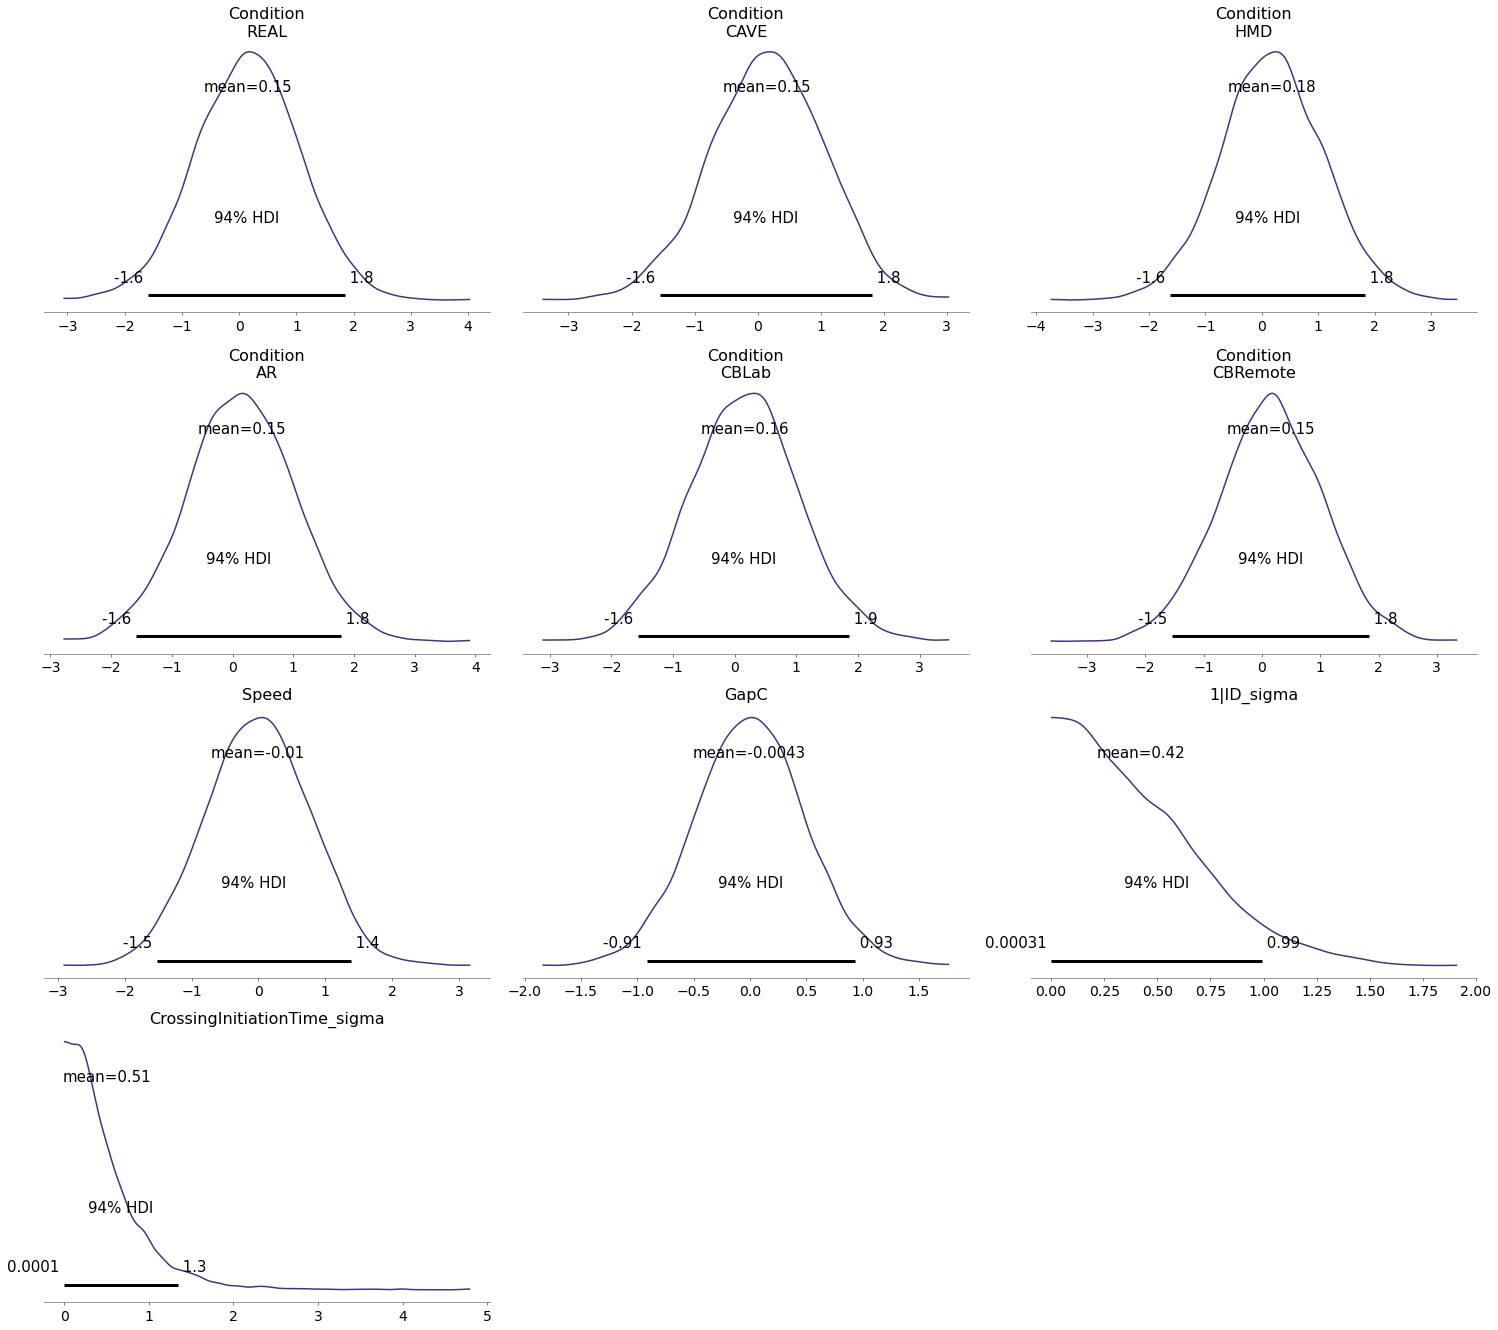

In [30]:
cit_model.plot_priors();

In [31]:
{x.name: x.prior.args for x in cit_model.terms.values()}

{'Condition': {'mu': array(0.15890205), 'sigma': array(0.89545075)},
 'Speed': {'mu': array(0), 'sigma': array(0.78679452)},
 'GapC': {'mu': array(0), 'sigma': array(0.48447313)},
 '1|ID': {'mu': array(0), 'sigma': HalfNormal(sigma: 0.51698873)}}

#### Fitting

C:\Users\phili\AppData\Roaming\Python\Python38\site-packages\pymc3\sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


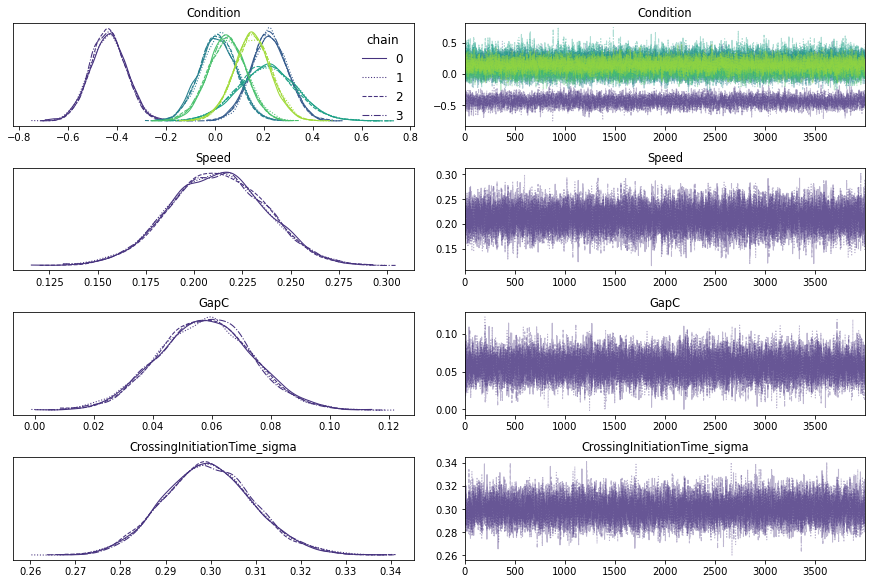

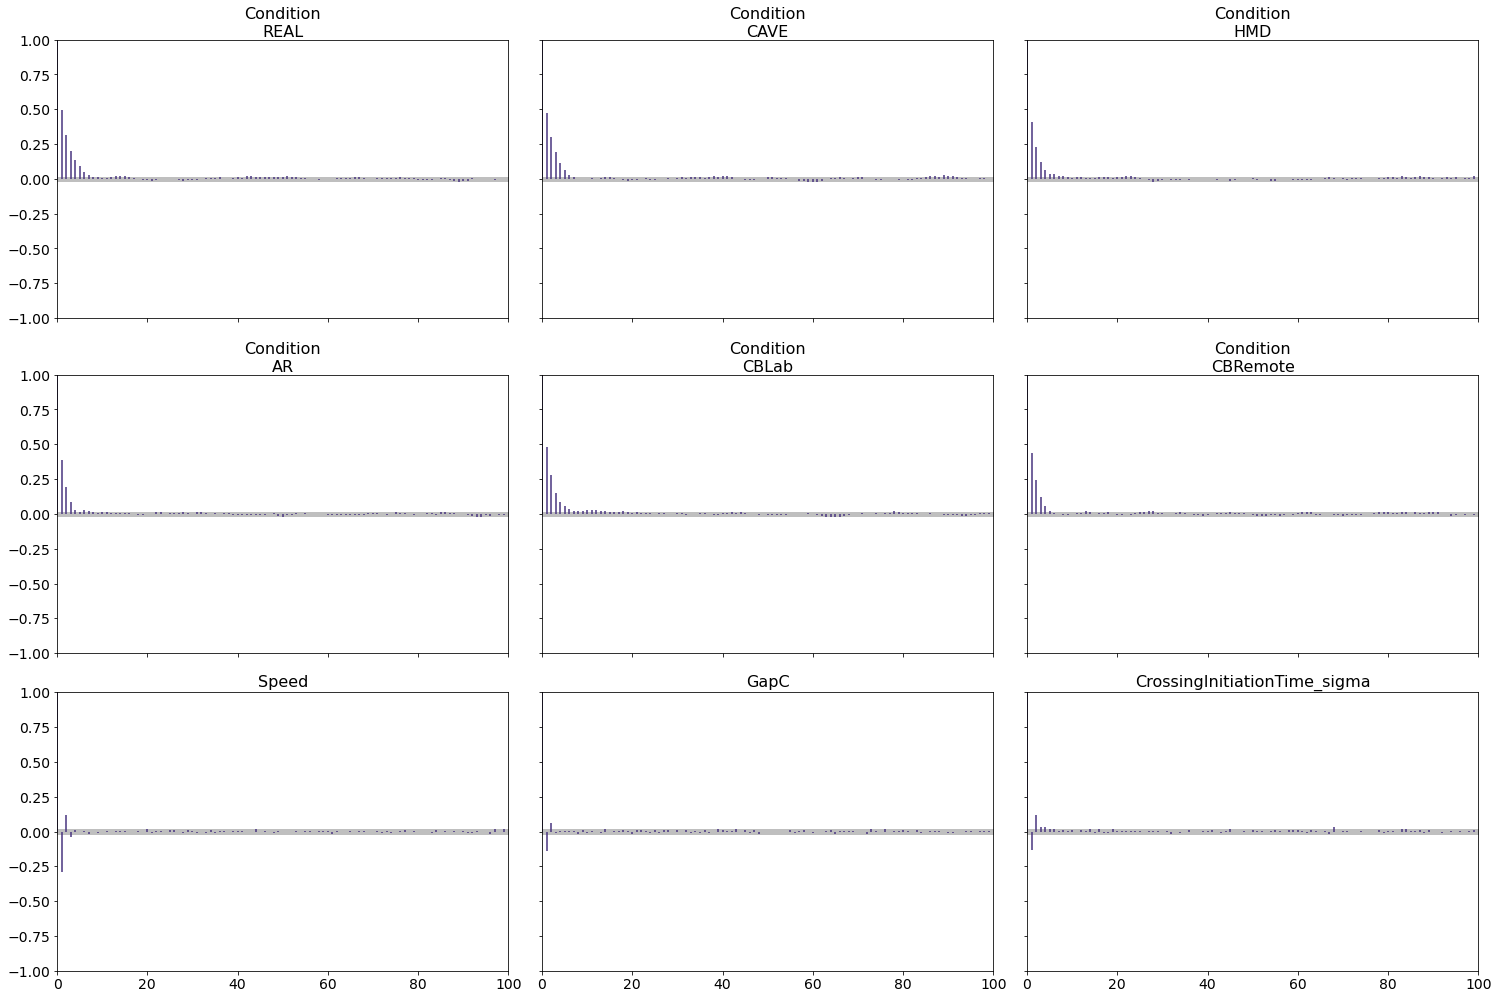

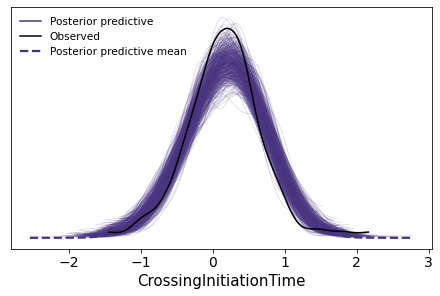

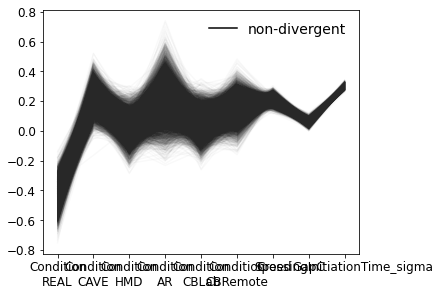

In [32]:
posterior_predictive = cit_model.posterior_predictive(cit_fitted, random_seed=RANDOM_SEED)
az.plot_trace(cit_fitted,var_names=["~ID"], filter_vars="regex",
              legend=True, compact=True);
az.plot_autocorr(cit_fitted,var_names=["~ID"], filter_vars="regex", combined = True);
az.plot_ppc(cit_fitted);
az.plot_parallel(cit_fitted,var_names=["~ID"], filter_vars="regex", legend = True);

### Inference

#### Posteriors

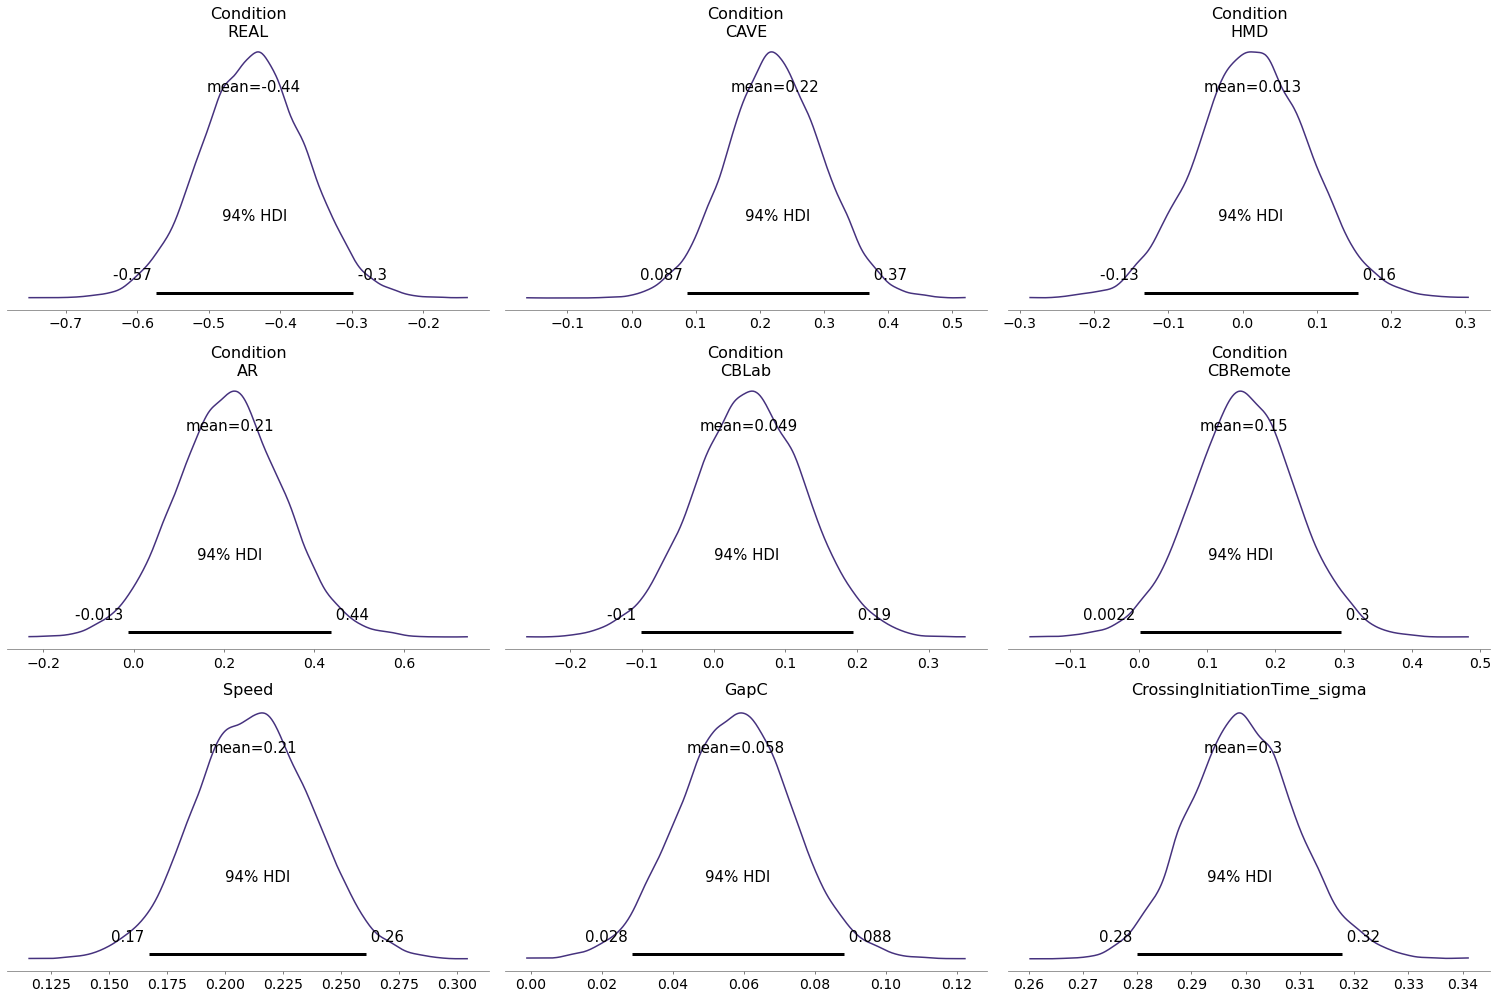

In [33]:
az.plot_posterior(cit_fitted,var_names=["~ID"], filter_vars="regex");

#### Differences

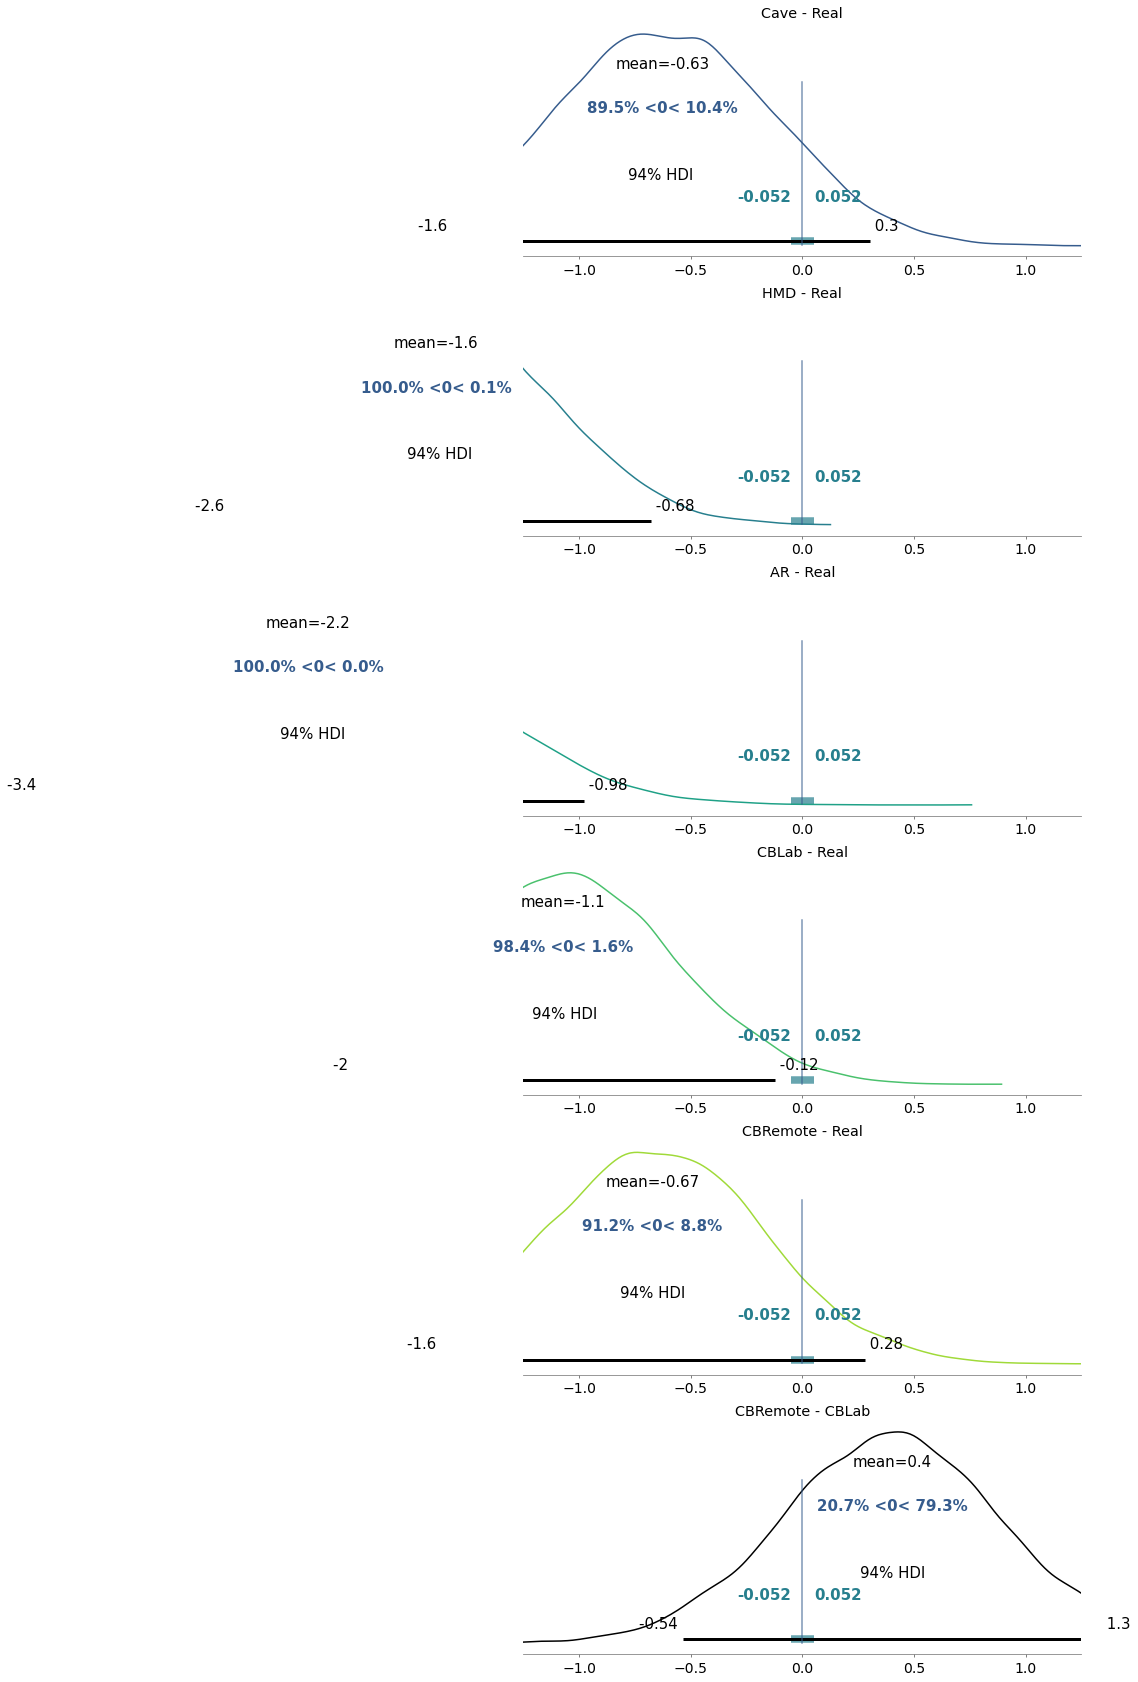

In [34]:
fig, axes = plt.subplots(6, 1, figsize=(10,30))
ax = 0
colors = sns.color_palette(palette = 'viridis')
colors.append('#000000')

cit_sd = df['CrossingInitiationTime'].std()

titels = ['Cave - Real','HMD - Real','AR - Real','CBLab - Real','CBRemote - Real','CBRemote - CBLab']
for compare in [CAVE - REAL,HMD - REAL,AR - REAL,CBLab - REAL,CBRemote - REAL,CBRemote- CBLab]:
    az.plot_posterior(compare, skipna = True, ref_val = 0, rope = (-0.1*cit_sd, 0.1*cit_sd),
                      ax = axes[ax],color=colors[ax+1]).set_title(titels[ax]);
    plt.setp(axes[ax], xlim=(-1.25, 1.25))
    ax += 1

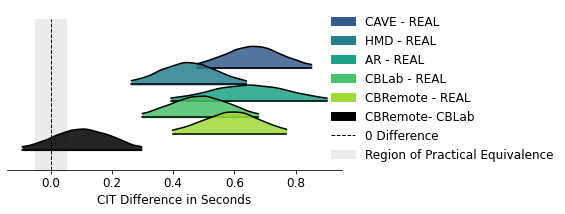

In [35]:
Conditions = ['REAL','CAVE','HMD','AR','CBLab','CBRemote']
REAL, CAVE, HMD, AR, CBLab, CBRemote = [cit_fitted.posterior['Condition'][:,:,diff].values for diff in [0,1,2,3,4,5]]
fig, ax = plt.subplots(figsize=(6, 3))

ax.vlines(0,-10,18,'black', 'dashed', zorder=-10,lw=1)
az.plot_forest([CAVE - REAL,HMD - REAL,AR - REAL,CBLab - REAL,CBRemote - REAL, CBRemote - CBLab],
                model_names = ['Cave - Real','HMD - Real','AR - Real','CBLab - Real','CBRemote - Real','CBRemote - CBLab'],
                kind='ridgeplot',
                combined=True,
                ridgeplot_overlap=3,
                ridgeplot_alpha=0.85,
                colors=colors,
                ax=ax)
ax.spines['top'].set_color('white')
ax.add_patch(matplotlib.patches.Rectangle((-0.1*cit_sd,-10), 0.2*cit_sd, 28, zorder=-100,color="#ebebeb"))
ax.set_yticks([])
ax.set(xlabel='CIT Difference in Seconds')

cave_patch = mpatches.Patch(color=colors[1], label='CAVE - REAL')
hmd_patch = mpatches.Patch(color=colors[2], label='HMD - REAL')
ar_patch = mpatches.Patch(color=colors[3], label='AR - REAL')
cblab_patch = mpatches.Patch(color=colors[4], label='CBLab - REAL')
cbremote_patch = mpatches.Patch(color=colors[5], label='CBRemote - REAL')
cbdiff_patch = mpatches.Patch(color=colors[6], label='CBRemote- CBLab')
line = Line2D([0], [0], color='black',ls='dashed', lw=1, label='0 Difference')

rope_patch = mpatches.Patch(color="#ebebeb", label='Region of Practical Equivalence')
ax.legend(handles=[cave_patch,hmd_patch,ar_patch,cblab_patch,cbremote_patch,cbdiff_patch,line,rope_patch], 
          bbox_to_anchor=(1.3, 0.5),loc='center');

## Subjective Data

Q1: How safe would it have been to cross the street?

Q2: How likely would a collision have been?

Q3: How dangerous would a collision have been?

Q4: How similar to real world traffic was your behavior in cases when you crossed the street?

Q5: How similar to real world traffic was your behavior in cases when you did not cross the street?

Q6: Compared to usual, my choices were safe / unsafe

Q7: Compared to usual, deciding to cross the street was easy / difficult

Q8: Compared to usual, making a decision took longer / shorter

In [36]:
#Create Dummy codes for Simulator Conditions
dummies = pd.get_dummies(df_subjectives['Condition'])

### How safe would it have been to cross the street?

In [37]:
#log-cumulative-odds cutpoints
lco = df_subjectives["Q1"].value_counts(normalize=True, sort=False).cumsum().apply(sp.special.logit)
lco.round(2)

1   -4.43
2   -1.76
3    1.15
4     inf
Name: Q1, dtype: float64

In [38]:
with pm.Model() as Q1_model:
    cutpoints = pm.Normal(
        "cutpoints",
        0,
        1.5,
        transform=pm.distributions.transforms.ordered,
        shape=3,
        testval=np.arange(3),
    )
    bREAL = pm.Normal("bREAL", 0.0, 0.5)
    REAL = pm.Data("REAL", dummies.REAL.values)
    
    bCAVE = pm.Normal("bCAVE", 0.0, 0.5)
    CAVE = pm.Data("CAVE", dummies.CAVE.values)
    
    bHMD = pm.Normal("bHMD", 0.0, 0.5)
    HMD = pm.Data("HMD", dummies.HMD.values)
    
    bAR = pm.Normal("bAR", 0.0, 0.5)
    AR = pm.Data("AR", dummies.AR.values)
    
    bCBLab = pm.Normal("bCBLab", 0.0, 0.5)
    CBLab = pm.Data("CBLab", dummies.CBLab.values)
    
    bCBRemote = pm.Normal("bCBRemote", 0.0, 0.5)
    CBRemote = pm.Data("CBRemote", dummies.CBRemote.values)
    
    eta = pm.Deterministic("eta", bREAL * REAL + bCAVE * CAVE + bHMD * HMD + bAR * AR + bCBLab * CBLab + bCBRemote * CBRemote)

    Q1 = pm.OrderedLogistic("Q1", eta, cutpoints, observed=df_subjectives["Q1"].values -1)
    
    trace_Q1 = pm.sample(return_inferencedata=True, tune = 1000, target_accept=0.85, random_seed=RANDOM_SEED)


REAL, CAVE, HMD, AR, CBLab, CBRemote = [trace_Q1.posterior[x].values for x in ['bREAL','bCAVE','bHMD','bAR','bCBLab','bCBRemote']]
Q1_diffs = [CAVE - REAL,HMD - REAL,AR - REAL,CBLab - REAL,CBRemote - REAL,CBRemote- CBLab]

az.summary(trace_Q1, round_to=2,var_names=["~eta"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bCBRemote, bCBLab, bAR, bHMD, bCAVE, bREAL, cutpoints]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
bREAL         0.92  0.33    0.31     1.56       0.01     0.00   3664.87   
bCAVE        -0.35  0.34   -0.97     0.28       0.01     0.00   4319.94   
bHMD          0.00  0.33   -0.59     0.65       0.00     0.00   4595.40   
bAR           0.27  0.39   -0.47     1.01       0.01     0.01   4655.16   
bCBLab       -0.55  0.34   -1.20     0.10       0.01     0.00   3513.61   
bCBRemote     0.16  0.33   -0.46     0.79       0.01     0.00   3994.30   
cutpoints[0] -4.01  0.56   -5.12    -2.99       0.01     0.01   2184.48   
cutpoints[1] -1.72  0.29   -2.28    -1.21       0.00     0.00   3349.96   
cutpoints[2]  1.31  0.27    0.83     1.83       0.00     0.00   2995.41   

              ess_tail  r_hat  
bREAL          2569.31    1.0  
bCAVE          2792.45    1.0  
bHMD           3145.55    1.0  
bAR            2761.02    1.0  
bCBLab         2727.22    1.0  
bCBRemote      2945.69    1.0  
cutpoints[0]   1081.52    1.0  
cutpoints[1]   3343.76    1.0  
cutpoints[2]   2879.41    1.0

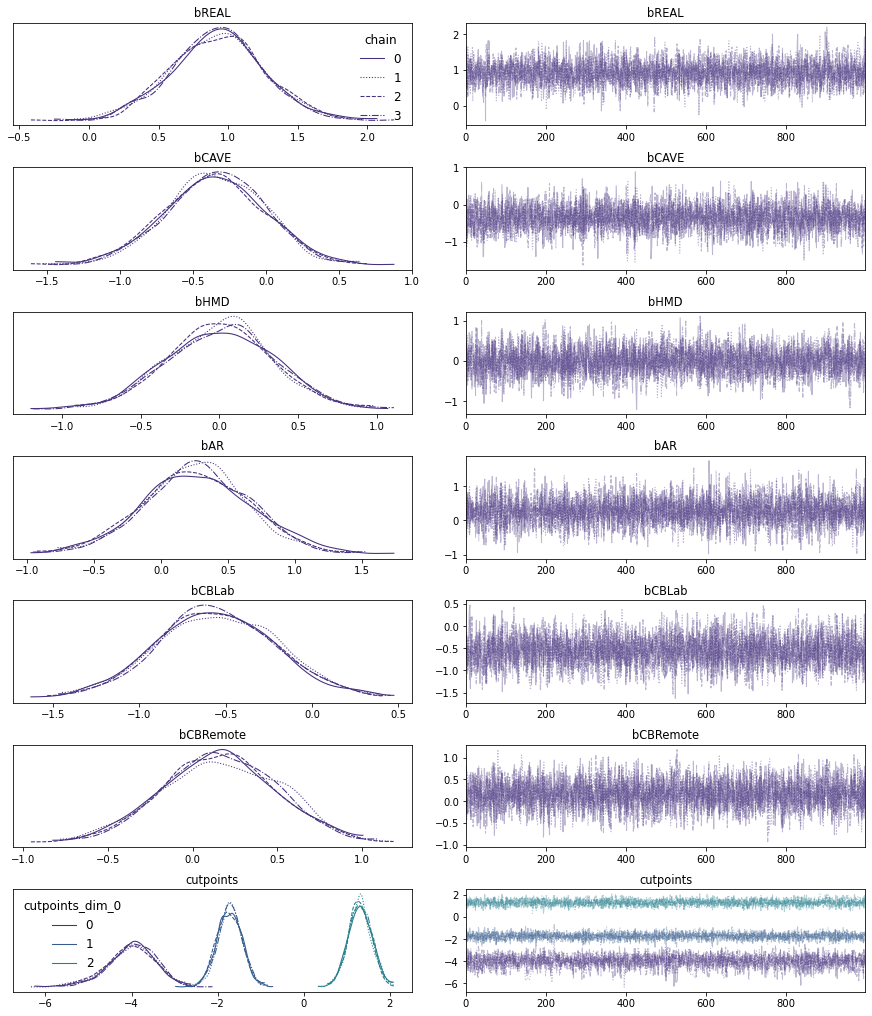

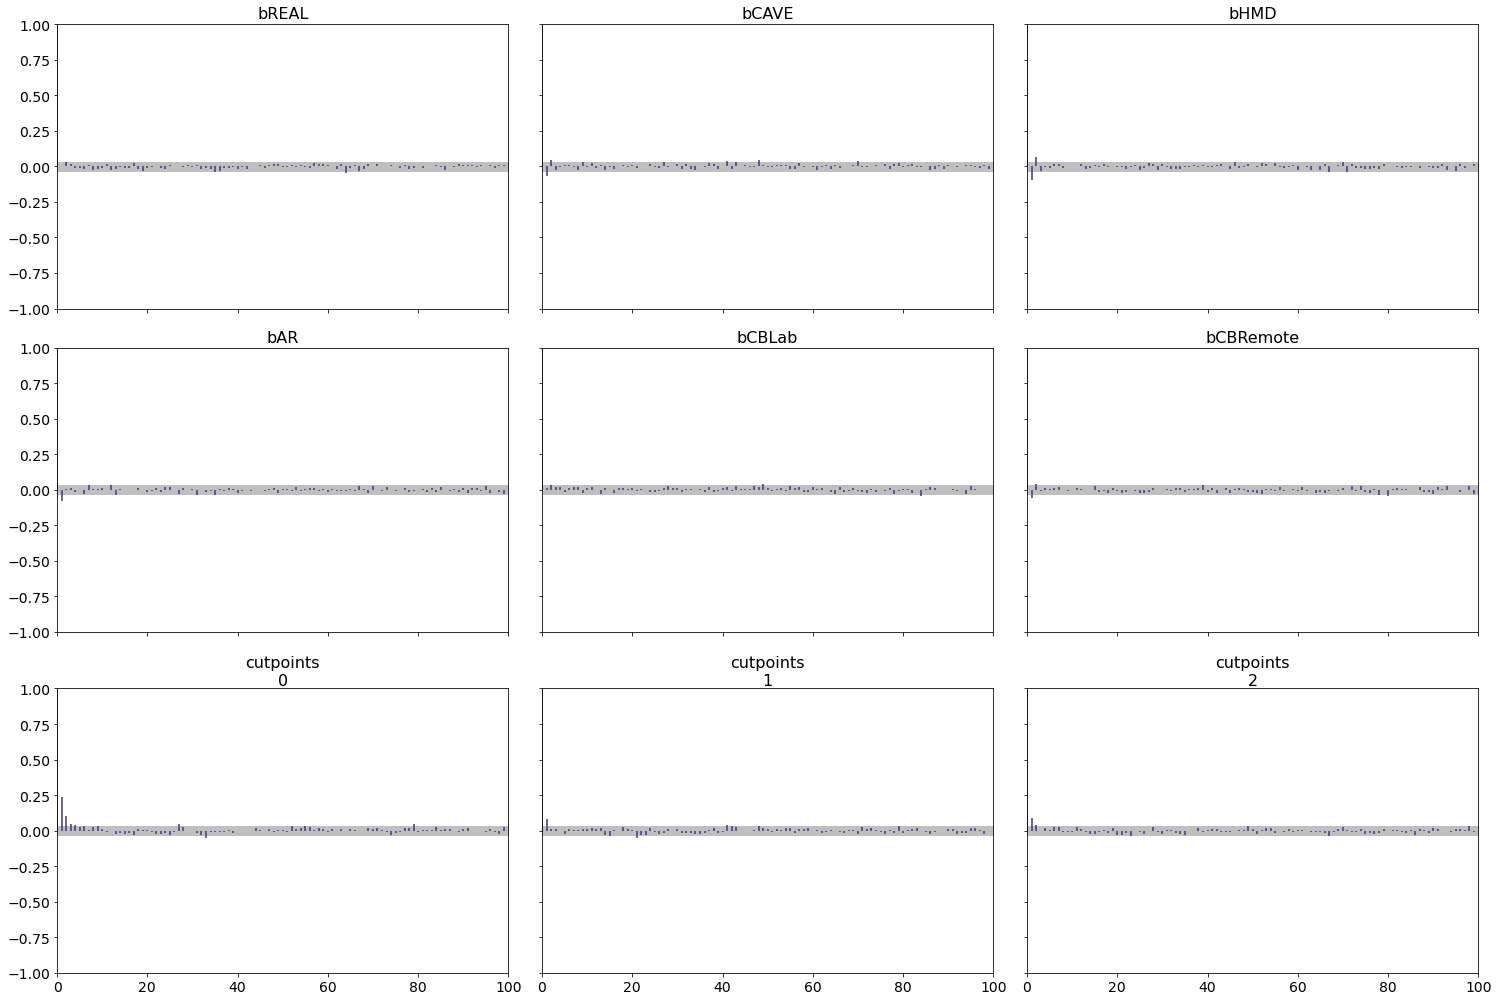

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


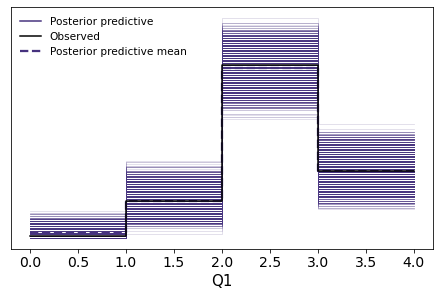

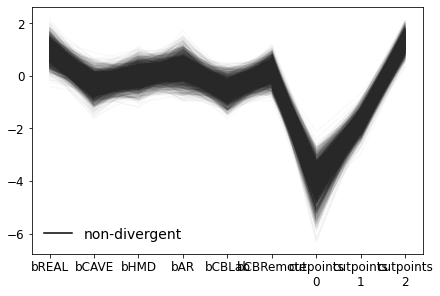

In [39]:
with Q1_model:
    ppc = pm.sample_posterior_predictive(trace_Q1, random_seed=RANDOM_SEED)

az.plot_trace(trace_Q1,var_names=["~eta"], filter_vars="regex",legend=True, compact=True);
az.plot_autocorr(trace_Q1,var_names=["~eta"], filter_vars="regex", combined = True);
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=Q1_model));
az.plot_parallel(trace_Q1,var_names=["~eta"], filter_vars="regex", legend = True);

### How likely would a collision have been?

In [40]:
#log-cumulative-odds cutpoints
lco = df_subjectives["Q2"].value_counts(normalize=True, sort=False).cumsum().apply(sp.special.logit)
lco.round(2)

1   -0.55
2    2.01
3    3.50
4     inf
Name: Q2, dtype: float64

In [41]:
with pm.Model() as Q2_model:
    cutpoints = pm.Normal(
        "cutpoints",
        0,
        1.5,
        transform=pm.distributions.transforms.ordered,
        shape=3,
        testval=np.arange(3),
    )
    bREAL = pm.Normal("bREAL", 0.0, 0.5)
    REAL = pm.Data("REAL", dummies.REAL.values)
    
    bCAVE = pm.Normal("bCAVE", 0.0, 0.5)
    CAVE = pm.Data("CAVE", dummies.CAVE.values)
    
    bHMD = pm.Normal("bHMD", 0.0, 0.5)
    HMD = pm.Data("HMD", dummies.HMD.values)
    
    bAR = pm.Normal("bAR", 0.0, 0.5)
    AR = pm.Data("AR", dummies.AR.values)
    
    bCBLab = pm.Normal("bCBLab", 0.0, 0.5)
    CBLab = pm.Data("CBLab", dummies.CBLab.values)
    
    bCBRemote = pm.Normal("bCBRemote", 0.0, 0.5)
    CBRemote = pm.Data("CBRemote", dummies.CBRemote.values)
    
    eta = pm.Deterministic("eta", bREAL * REAL + bCAVE * CAVE + bHMD * HMD + bAR * AR + bCBLab * CBLab + bCBRemote * CBRemote)

    Q2 = pm.OrderedLogistic("Q2", eta, cutpoints, observed=df_subjectives["Q2"].values -1)
    
    trace_Q2 = pm.sample(return_inferencedata=True, tune = 1000, target_accept=0.85, random_seed=RANDOM_SEED)


REAL, CAVE, HMD, AR, CBLab, CBRemote = [trace_Q2.posterior[x].values for x in ['bREAL','bCAVE','bHMD','bAR','bCBLab','bCBRemote']]
Q2_diffs = [CAVE - REAL,HMD - REAL,AR - REAL,CBLab - REAL,CBRemote - REAL,CBRemote- CBLab]

az.summary(trace_Q2, round_to=2,var_names=["~eta"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bCBRemote, bCBLab, bAR, bHMD, bCAVE, bREAL, cutpoints]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
bREAL        -0.33  0.32   -0.91     0.29       0.01      0.0   3858.35   
bCAVE         0.33  0.33   -0.32     0.94       0.01      0.0   4192.97   
bHMD          0.32  0.32   -0.27     0.92       0.01      0.0   4025.74   
bAR          -0.47  0.40   -1.23     0.26       0.01      0.0   5360.90   
bCBLab       -0.03  0.34   -0.66     0.59       0.01      0.0   3917.72   
bCBRemote    -0.30  0.33   -0.93     0.30       0.01      0.0   4096.79   
cutpoints[0] -0.63  0.25   -1.11    -0.17       0.00      0.0   2952.39   
cutpoints[1]  1.95  0.30    1.40     2.52       0.00      0.0   3767.78   
cutpoints[2]  3.34  0.43    2.55     4.11       0.01      0.0   4476.88   

              ess_tail  r_hat  
bREAL          3106.07    1.0  
bCAVE          3062.67    1.0  
bHMD           3447.81    1.0  
bAR            2747.01    1.0  
bCBLab         2432.18    1.0  
bCBRemote      3243.59    1.0  
cutpoints[0]   3033.55    1.0  
cutpoints[1]   3276.03    1.0  
cutpoints[2]   3021.08    1.0

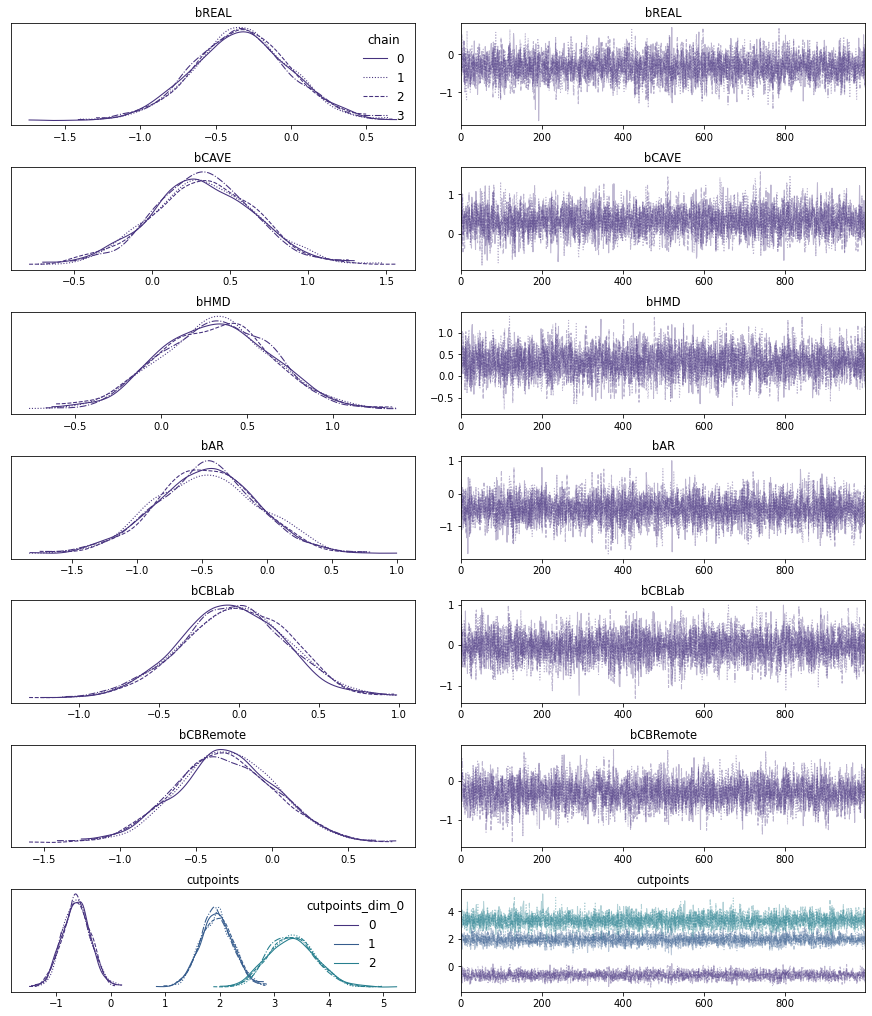

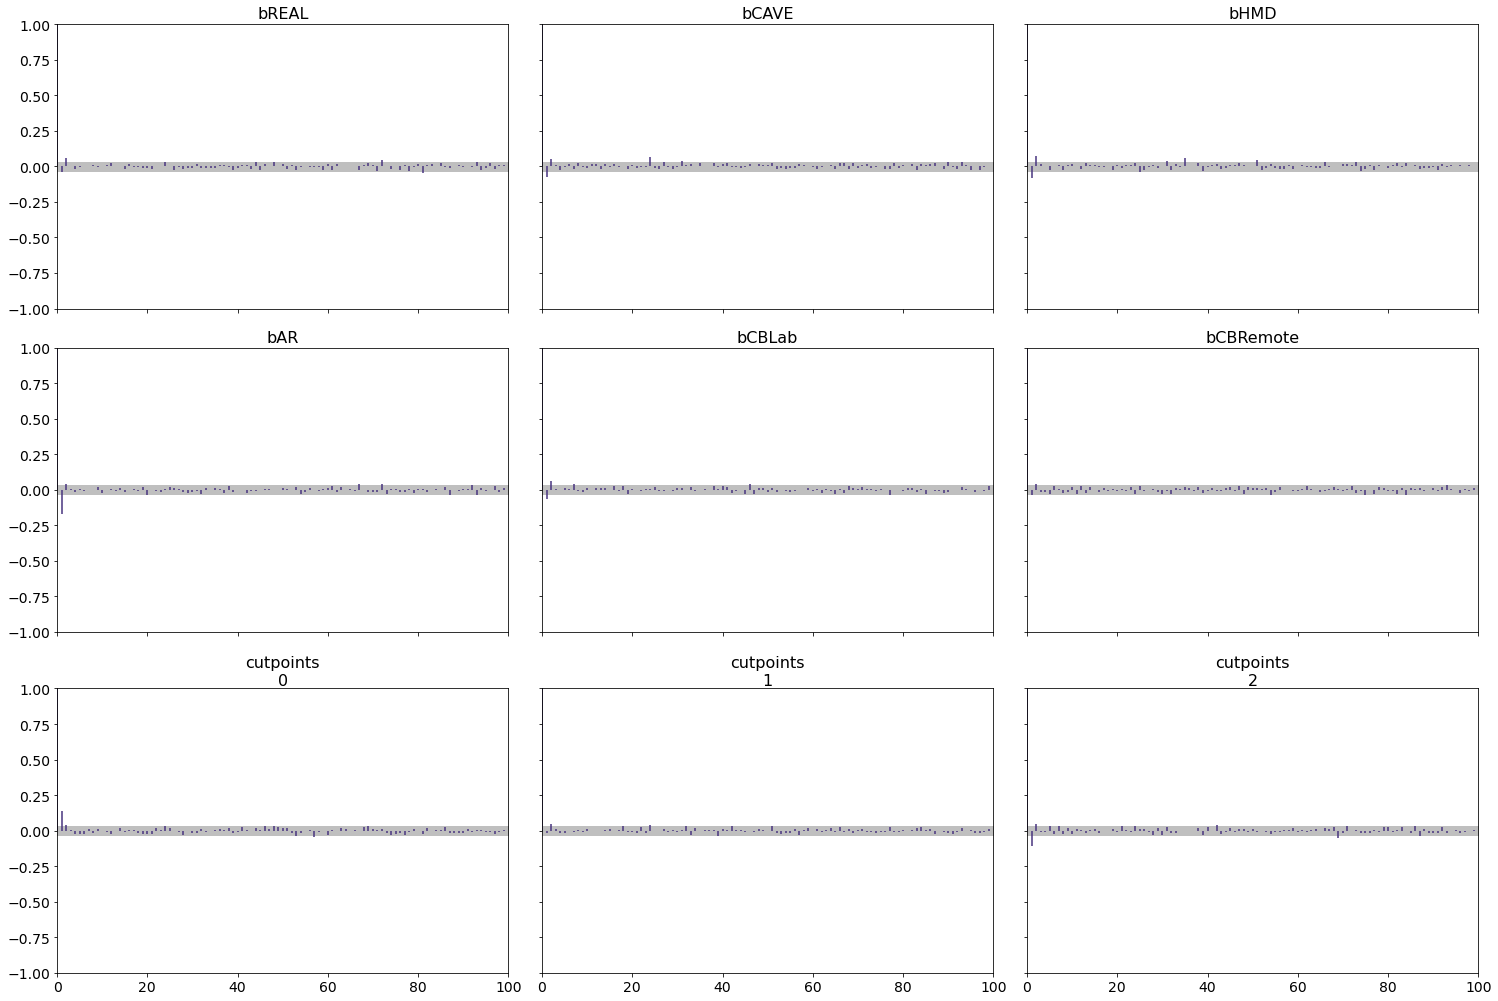

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


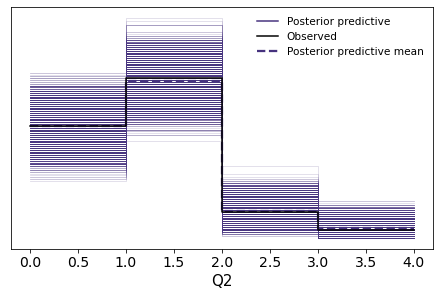

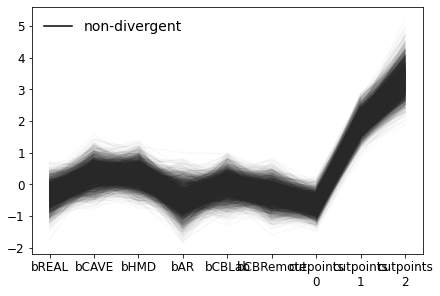

In [42]:
with Q2_model:
    ppc = pm.sample_posterior_predictive(trace_Q2, random_seed=RANDOM_SEED)

az.plot_trace(trace_Q2,var_names=["~eta"], filter_vars="regex",legend=True, compact=True);
az.plot_autocorr(trace_Q2,var_names=["~eta"], filter_vars="regex", combined = True);
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=Q2_model));
az.plot_parallel(trace_Q2,var_names=["~eta"], filter_vars="regex", legend = True);

### How dangerous would a collision have been?

In [43]:
#log-cumulative-odds cutpoints
lco = df_subjectives["Q3"].value_counts(normalize=True, sort=False).cumsum().apply(sp.special.logit)
lco.round(2)

2.0   -1.17
1.0   -0.95
3.0    1.34
4.0     inf
Name: Q3, dtype: float64

In [44]:
#delete nan rows
nanIDX = np.argwhere(np.isnan(df_subjectives["Q3"].values))[0][0]
obs = np.delete(df_subjectives["Q3"].values, nanIDX)
dummies_ = dummies.drop([nanIDX])

In [45]:
with pm.Model() as Q3_model:
    cutpoints = pm.Normal(
        "cutpoints",
        0,
        1.5,
        transform=pm.distributions.transforms.ordered,
        shape=3,
        testval=np.arange(3),
    )
    bREAL = pm.Normal("bREAL", 0.0, 0.5)
    REAL = pm.Data("REAL", dummies_.REAL.values)
    
    bCAVE = pm.Normal("bCAVE", 0.0, 0.5)
    CAVE = pm.Data("CAVE", dummies_.CAVE.values)
    
    bHMD = pm.Normal("bHMD", 0.0, 0.5)
    HMD = pm.Data("HMD", dummies_.HMD.values)
    
    bAR = pm.Normal("bAR", 0.0, 0.5)
    AR = pm.Data("AR", dummies_.AR.values)
    
    bCBLab = pm.Normal("bCBLab", 0.0, 0.5)
    CBLab = pm.Data("CBLab", dummies_.CBLab.values)
    
    bCBRemote = pm.Normal("bCBRemote", 0.0, 0.5)
    CBRemote = pm.Data("CBRemote", dummies_.CBRemote.values)
    
    eta = pm.Deterministic("eta", bREAL * REAL + bCAVE * CAVE + bHMD * HMD + bAR * AR + bCBLab * CBLab + bCBRemote * CBRemote)

    Q3 = pm.OrderedLogistic("Q3", eta, cutpoints, observed=obs -1)
    
    trace_Q3 = pm.sample(return_inferencedata=True, tune = 1000, random_seed=RANDOM_SEED)


REAL, CAVE, HMD, AR, CBLab, CBRemote = [trace_Q3.posterior[x].values for x in ['bREAL','bCAVE','bHMD','bAR','bCBLab','bCBRemote']]
Q3_diffs = [CAVE - REAL,HMD - REAL,AR - REAL,CBLab - REAL,CBRemote - REAL,CBRemote- CBLab]

az.summary(trace_Q3, round_to=2,var_names=["~eta"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bCBRemote, bCBLab, bAR, bHMD, bCAVE, bREAL, cutpoints]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.
The acceptance probability does not match the target. It is 0.8869180573092141, but should be close to 0.8. Try to increase the number of tuning steps.


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
bREAL         0.24  0.33   -0.35     0.87       0.01     0.00   2915.77   
bCAVE        -0.38  0.33   -0.98     0.25       0.01     0.00   2805.11   
bHMD         -0.22  0.32   -0.82     0.40       0.01     0.00   3064.18   
bAR           0.40  0.40   -0.39     1.11       0.01     0.00   3554.74   
bCBLab        0.21  0.32   -0.40     0.80       0.01     0.00   2806.47   
bCBRemote    -0.02  0.33   -0.62     0.60       0.01     0.00   2918.92   
cutpoints[0] -3.08  0.40   -3.84    -2.36       0.01     0.01   1672.74   
cutpoints[1] -0.96  0.26   -1.48    -0.51       0.01     0.00   1971.77   
cutpoints[2]  1.38  0.27    0.86     1.85       0.01     0.00   2365.29   

              ess_tail  r_hat  
bREAL          2986.33    1.0  
bCAVE          2781.18    1.0  
bHMD           3065.19    1.0  
bAR            2851.45    1.0  
bCBLab         2749.89    1.0  
bCBRemote      2797.20    1.0  
cutpoints[0]   2180.74    1.0  
cutpoints[1]   2844.88    1.0  
cutpoints[2]   2762.27    1.0

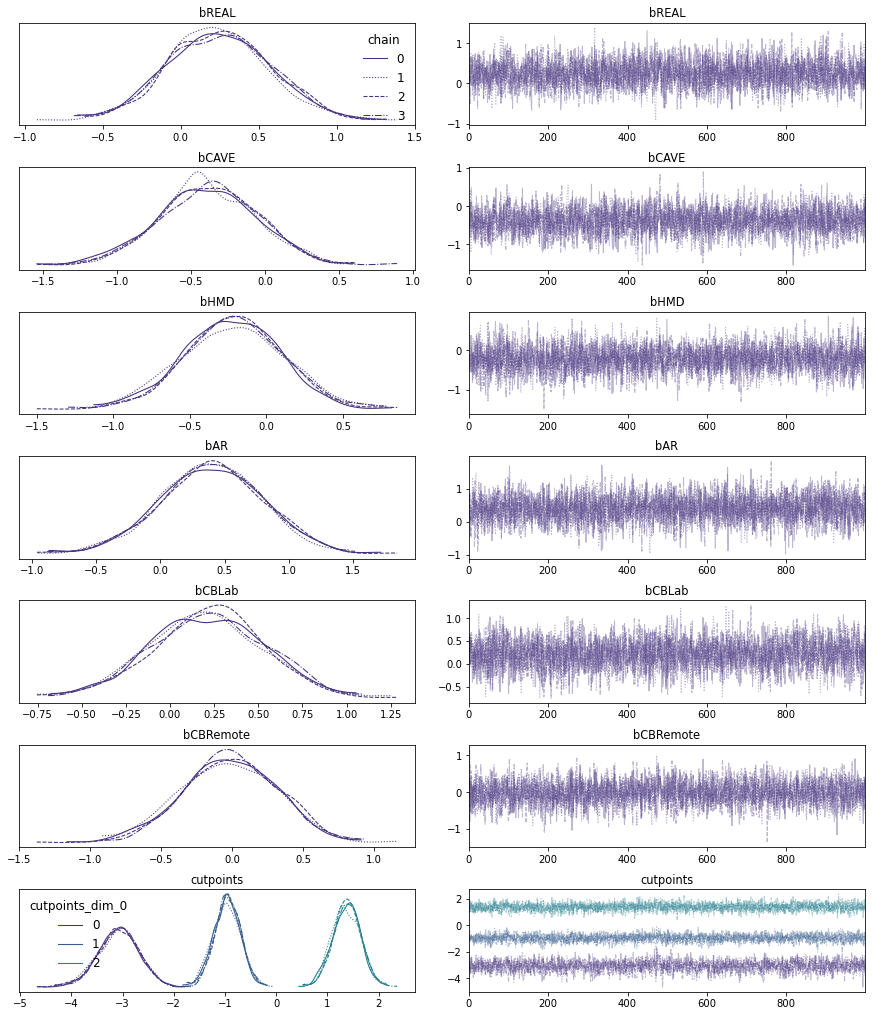

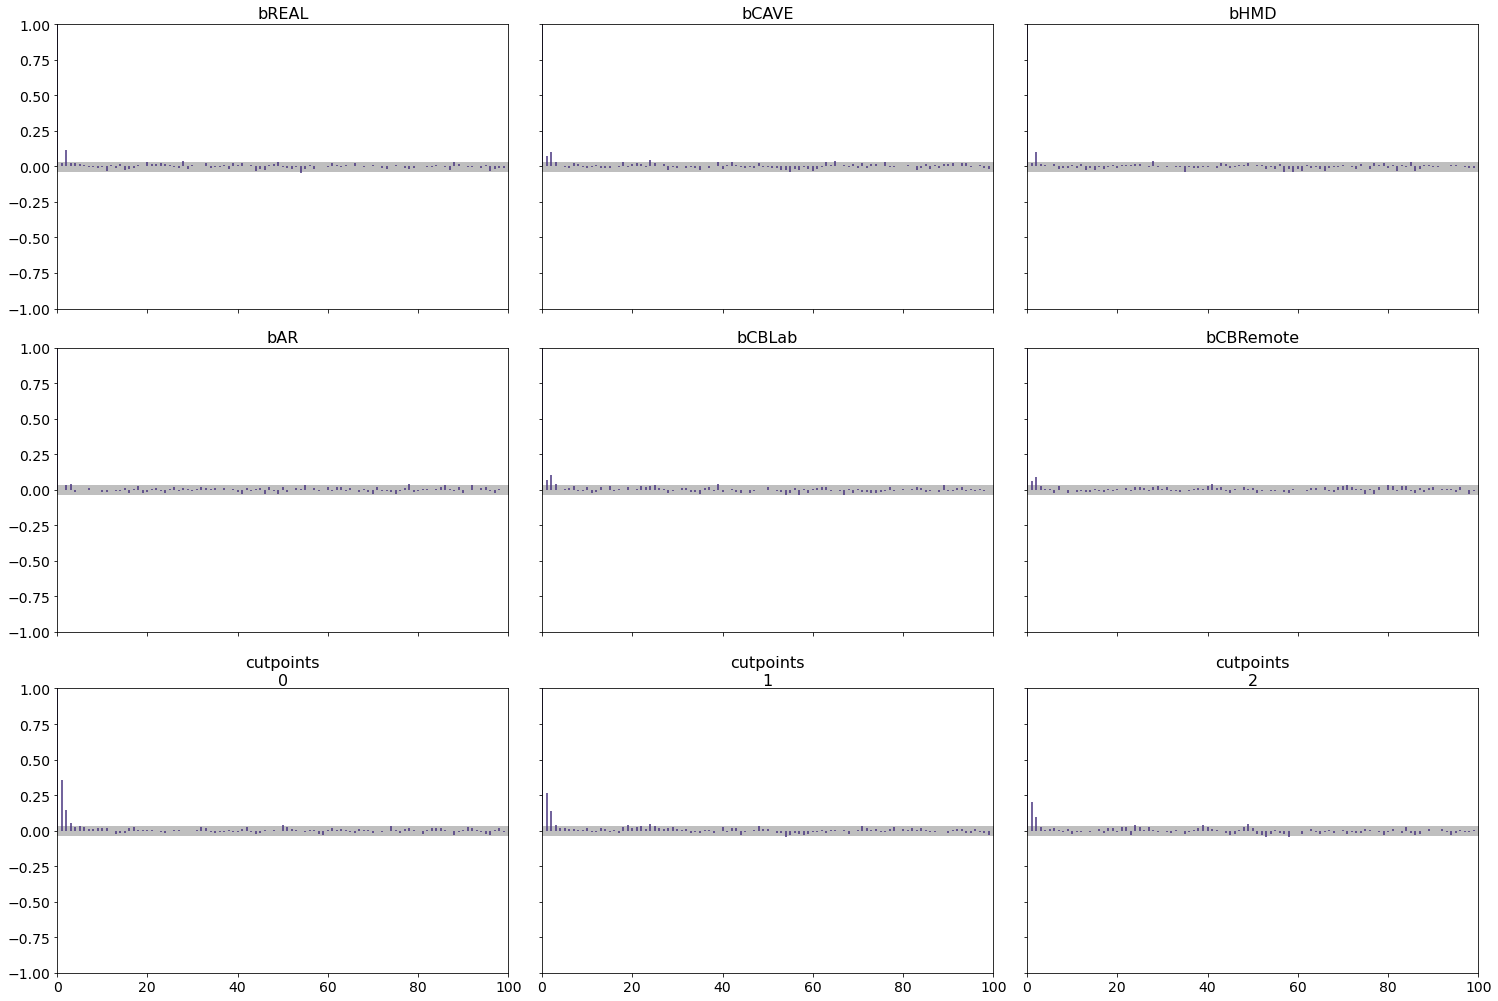

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


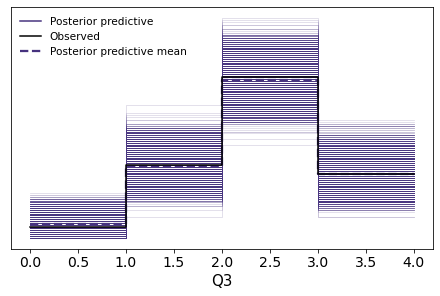

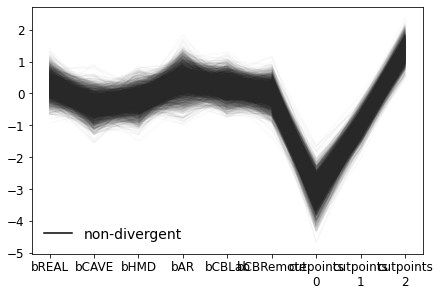

In [46]:
with Q3_model:
    ppc = pm.sample_posterior_predictive(trace_Q3, random_seed=RANDOM_SEED)

az.plot_trace(trace_Q3,var_names=["~eta"], filter_vars="regex",legend=True, compact=True);
az.plot_autocorr(trace_Q3,var_names=["~eta"], filter_vars="regex", combined = True);
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=Q3_model));
az.plot_parallel(trace_Q3,var_names=["~eta"], filter_vars="regex", legend = True);

### How similar to real world traffic was your behavior in cases when you crossed the street?

In [47]:
model = bmb.Model(df_subjectives, dropna=True)
fitted = model.fit("Q4 ~ 0+ Condition",categorical="Condition")
REAL, CAVE, HMD, AR, CBLab, CBRemote = [fitted.posterior['Condition'][:,:,x].values for x in [0,1,2,3,4,5]]
Q4_diffs = [CAVE - REAL,HMD - REAL,AR - REAL,CBLab - REAL,CBRemote - REAL,CBRemote- CBLab]
az.summary(fitted)

Automatically removing 8/170 rows from the dataset.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Q4_sigma, Condition]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 38 seconds.


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Condition[0]   9.874  0.436   9.110   10.717      0.006    0.004    5323.0   
Condition[1]   8.801  0.486   7.971    9.788      0.006    0.004    6657.0   
Condition[2]   9.747  0.469   8.893   10.638      0.006    0.004    5716.0   
Condition[3]   8.827  0.678   7.591   10.126      0.008    0.006    7618.0   
Condition[4]   8.728  0.469   7.890    9.658      0.006    0.004    7141.0   
Condition[5]  10.209  0.476   9.379   11.166      0.006    0.004    7003.0   
Q4_sigma       2.572  0.147   2.289    2.840      0.002    0.001    6804.0   

              ess_tail  r_hat  
Condition[0]    3319.0    1.0  
Condition[1]    3226.0    1.0  
Condition[2]    3102.0    1.0  
Condition[3]    3590.0    1.0  
Condition[4]    3644.0    1.0  
Condition[5]    3447.0    1.0  
Q4_sigma        3165.0    1.0

C:\Users\phili\AppData\Roaming\Python\Python38\site-packages\pymc3\sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


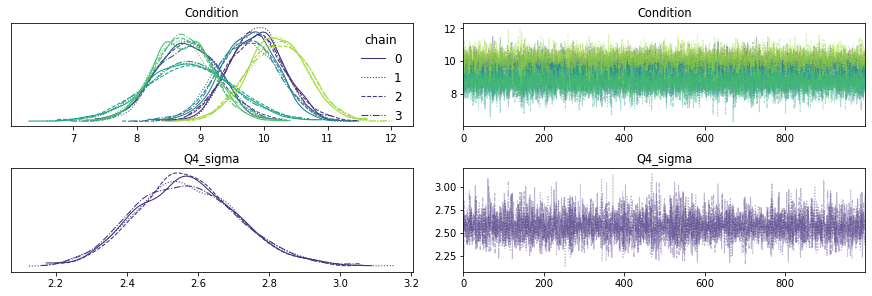

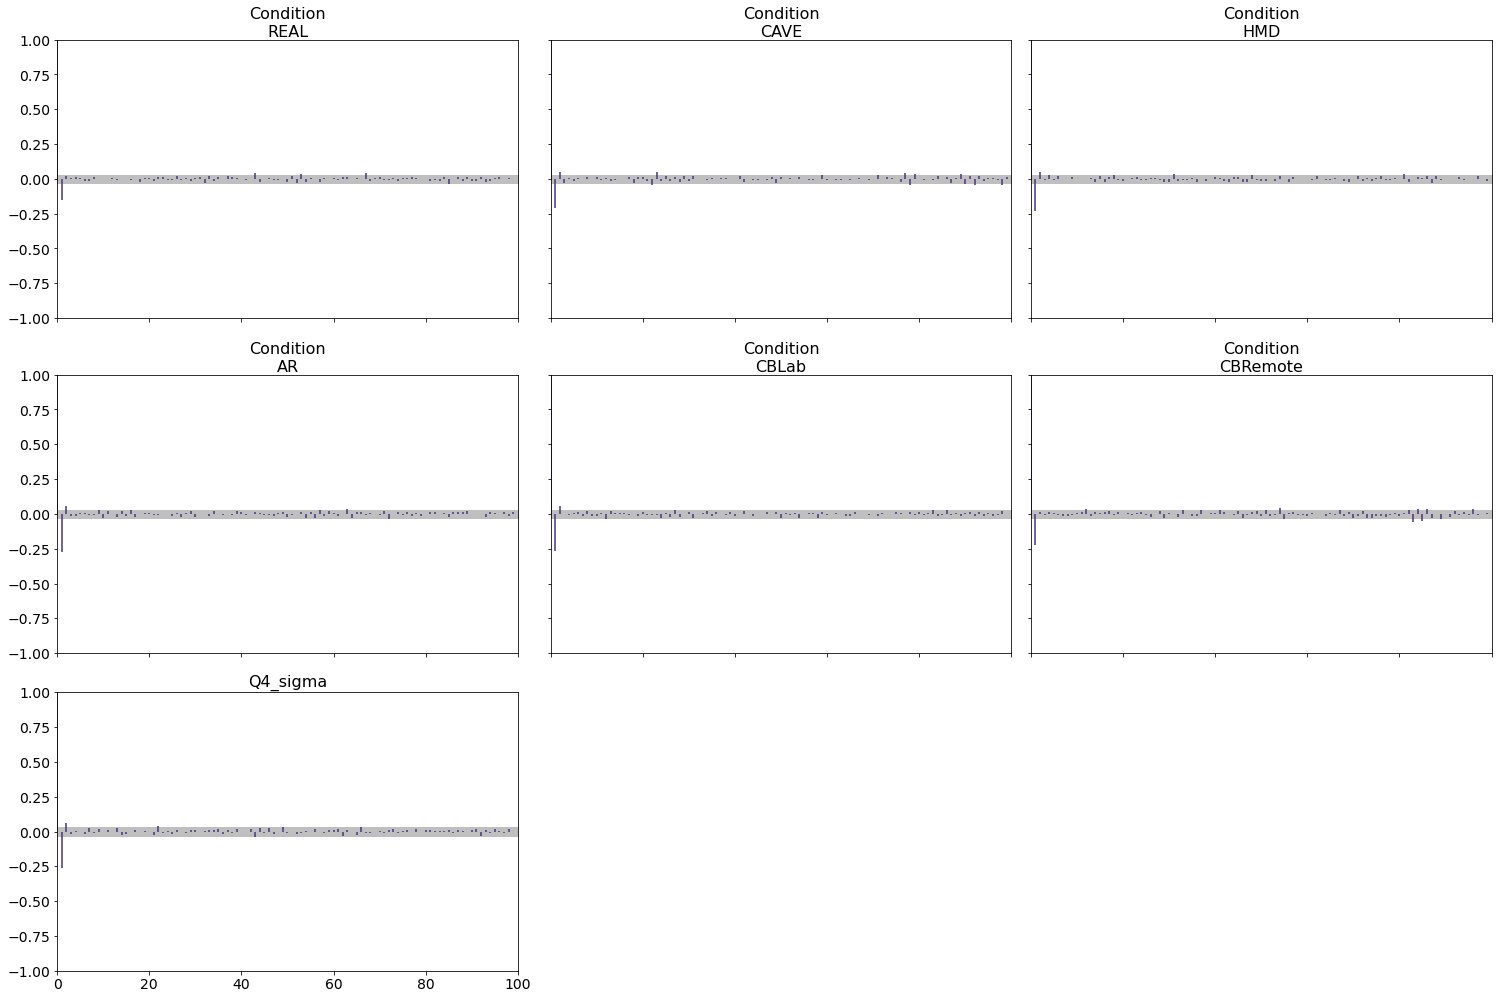

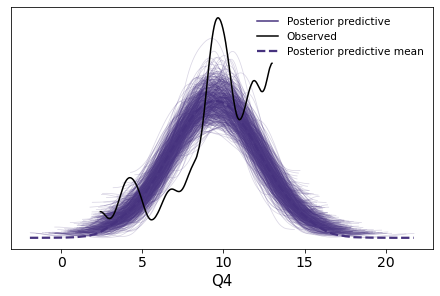

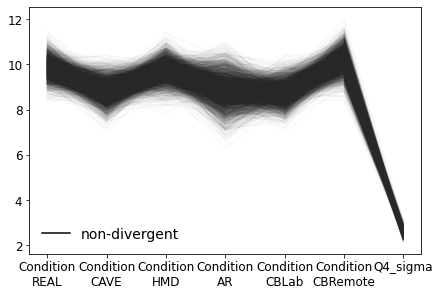

In [48]:
posterior_predictive = model.posterior_predictive(fitted,random_seed = RANDOM_SEED)

az.plot_trace(fitted,legend=True, compact=True);    
az.plot_autocorr(fitted, combined = True);
az.plot_ppc(fitted);
az.plot_parallel(fitted, legend = True);

### How similar to real world traffic was your behavior in cases  you did not cross the street?

In [49]:
model = bmb.Model(df_subjectives, dropna=True)
fitted = model.fit("Q5 ~ 0+ Condition",categorical=["Condition"],family="gaussian")
REAL, CAVE, HMD, AR, CBLab, CBRemote = [fitted.posterior['Condition'][:,:,x].values for x in [0,1,2,3,4,5]]
Q5_diffs = [CAVE - REAL,HMD - REAL,AR - REAL,CBLab - REAL,CBRemote - REAL,CBRemote- CBLab]
az.summary(fitted)

Automatically removing 10/170 rows from the dataset.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Q5_sigma, Condition]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 41 seconds.


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Condition[0]  10.253  0.468   9.352   11.098      0.006    0.004    6314.0   
Condition[1]  10.321  0.541   9.381   11.377      0.007    0.005    6311.0   
Condition[2]  10.439  0.516   9.445   11.347      0.006    0.004    7736.0   
Condition[3]   8.619  0.816   7.108   10.150      0.010    0.007    6227.0   
Condition[4]   9.226  0.501   8.263   10.147      0.006    0.004    7142.0   
Condition[5]  11.176  0.516  10.232   12.133      0.007    0.005    5138.0   
Q5_sigma       2.802  0.160   2.509    3.102      0.002    0.002    5100.0   

              ess_tail  r_hat  
Condition[0]    3107.0   1.00  
Condition[1]    2986.0   1.01  
Condition[2]    3481.0   1.00  
Condition[3]    3207.0   1.00  
Condition[4]    2789.0   1.00  
Condition[5]    3194.0   1.00  
Q5_sigma        3501.0   1.00

C:\Users\phili\AppData\Roaming\Python\Python38\site-packages\pymc3\sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


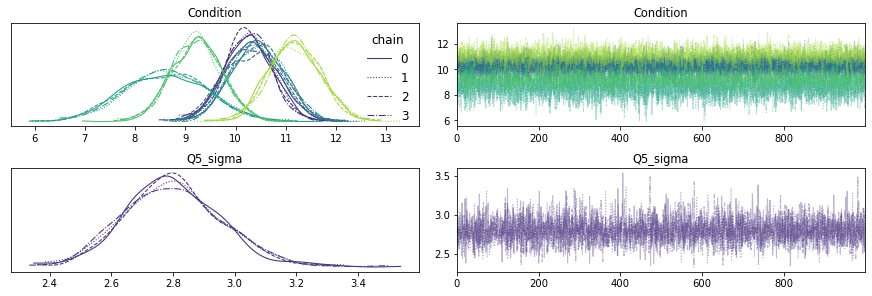

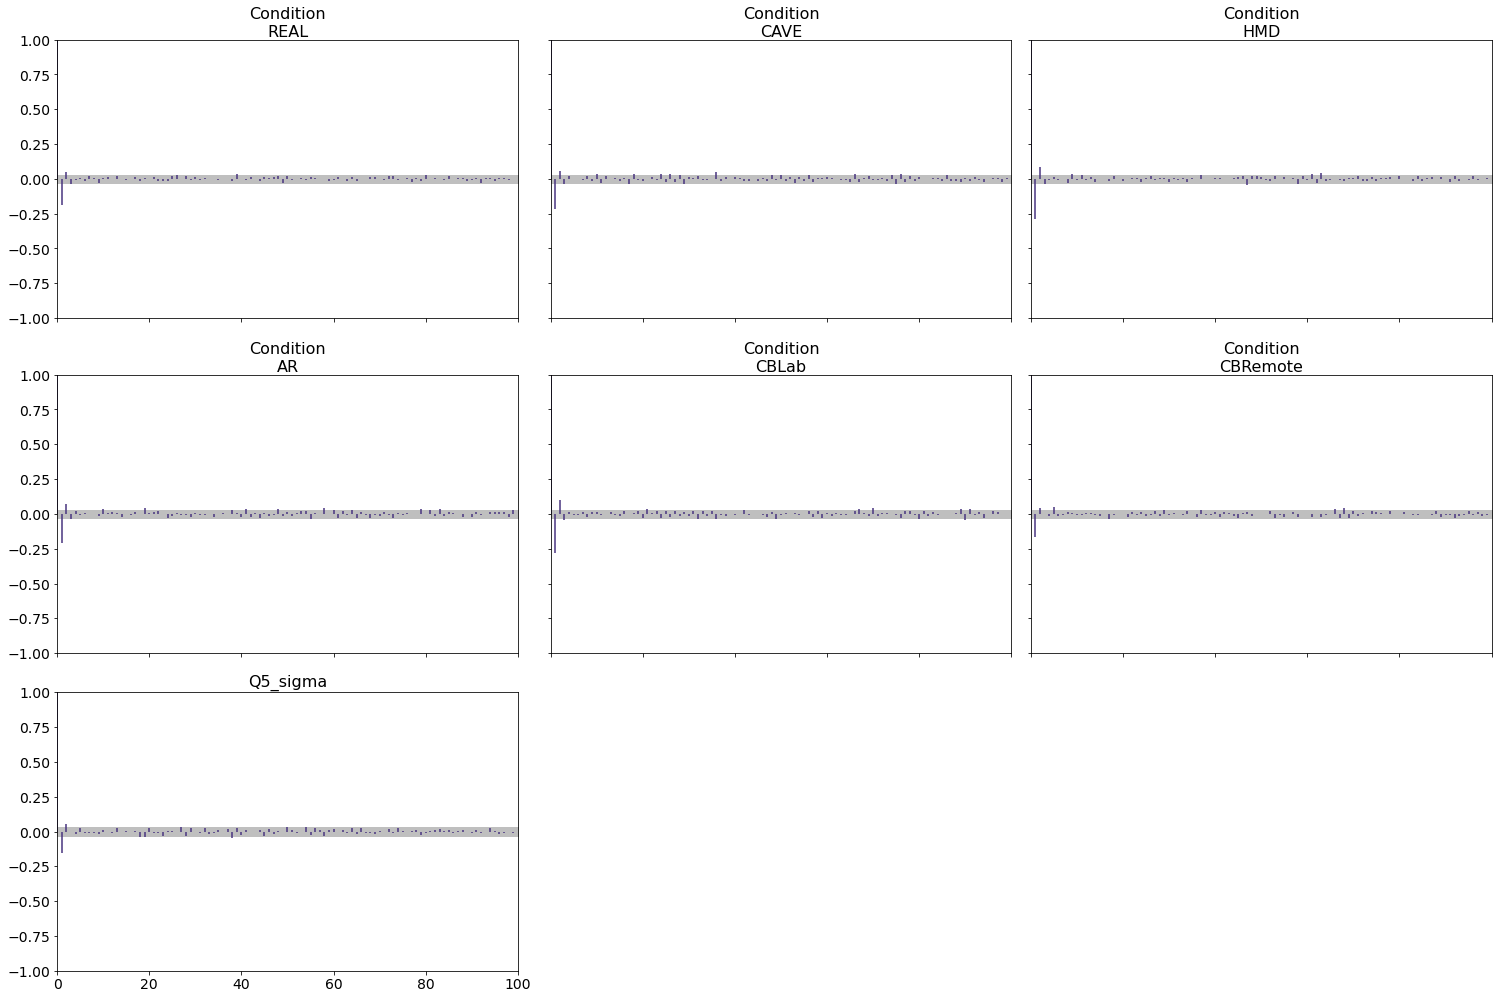

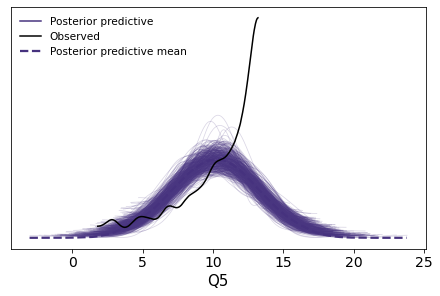

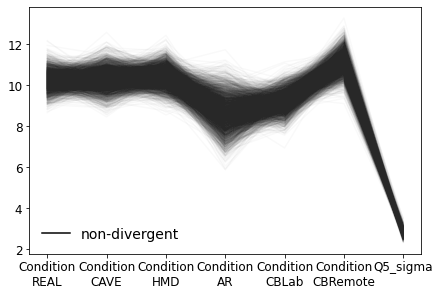

In [50]:
posterior_predictive = model.posterior_predictive(fitted,random_seed = RANDOM_SEED)

az.plot_trace(fitted,legend=True, compact=True);    
az.plot_autocorr(fitted, combined = True);
az.plot_ppc(fitted);
az.plot_parallel(fitted, legend = True);

### Compared to usual, my choices were safe / unsafe

In [51]:
#log-cumulative-odds cutpoints
lco = df_subjectives["Q6"].value_counts(normalize=True, sort=False).cumsum().apply(sp.special.logit)
lco.round(2)

 0.0    0.11
 2.0    0.18
-2.0    0.25
 1.0    1.53
-1.0     inf
Name: Q6, dtype: float64

In [52]:
#delete nan rows
nanIDX = np.argwhere(np.isnan(df_subjectives["Q6"].values))[0][0]
obs = np.delete(df_subjectives["Q6"].values, nanIDX)
dummies_ = dummies.drop([nanIDX])

In [53]:
with pm.Model() as Q6_model:
    cutpoints = pm.Normal(
        "cutpoints",
        0,
        1.5,
        transform=pm.distributions.transforms.ordered,
        shape=4,
        testval=np.arange(4),
    )
    bREAL = pm.Normal("bREAL", 0.0, 0.5)
    REAL = pm.Data("REAL", dummies_.REAL.values)
    
    bCAVE = pm.Normal("bCAVE", 0.0, 0.5)
    CAVE = pm.Data("CAVE", dummies_.CAVE.values)
    
    bHMD = pm.Normal("bHMD", 0.0, 0.5)
    HMD = pm.Data("HMD", dummies_.HMD.values)
    
    bAR = pm.Normal("bAR", 0.0, 0.5)
    AR = pm.Data("AR", dummies_.AR.values)
    
    bCBLab = pm.Normal("bCBLab", 0.0, 0.5)
    CBLab = pm.Data("CBLab", dummies_.CBLab.values)
    
    bCBRemote = pm.Normal("bCBRemote", 0.0, 0.5)
    CBRemote = pm.Data("CBRemote", dummies_.CBRemote.values)
    
    eta = pm.Deterministic("eta", bREAL * REAL + bCAVE * CAVE + bHMD * HMD + bAR * AR + bCBLab * CBLab + bCBRemote * CBRemote)

    Q6 = pm.OrderedLogistic("Q6", eta, cutpoints, observed = obs + 2)
    
    trace_Q6 = pm.sample(return_inferencedata=True, tune = 1000, random_seed=RANDOM_SEED)


REAL, CAVE, HMD, AR, CBLab, CBRemote = [trace_Q6.posterior[x].values for x in ['bREAL','bCAVE','bHMD','bAR','bCBLab','bCBRemote']]
Q6_diffs = [CAVE - REAL,HMD - REAL,AR - REAL,CBLab - REAL,CBRemote - REAL,CBRemote- CBLab]

az.summary(trace_Q6, round_to=2,var_names=["~eta"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bCBRemote, bCBLab, bAR, bHMD, bCAVE, bREAL, cutpoints]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
The acceptance probability does not match the target. It is 0.879737964941804, but should be close to 0.8. Try to increase the number of tuning steps.


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
bREAL        -0.38  0.31   -0.96     0.19       0.01     0.00   3460.48   
bCAVE        -0.07  0.32   -0.67     0.53       0.01     0.00   3344.87   
bHMD          0.44  0.33   -0.19     1.02       0.01     0.00   3947.26   
bAR           0.10  0.38   -0.60     0.80       0.01     0.01   4028.52   
bCBLab        0.07  0.32   -0.53     0.64       0.01     0.00   3640.33   
bCBRemote    -0.12  0.33   -0.73     0.50       0.01     0.00   3911.41   
cutpoints[0] -3.74  0.49   -4.71    -2.92       0.01     0.01   2377.91   
cutpoints[1] -1.44  0.27   -1.97    -0.94       0.01     0.00   2855.45   
cutpoints[2]  0.93  0.26    0.45     1.40       0.00     0.00   3086.42   
cutpoints[3]  3.73  0.50    2.79     4.66       0.01     0.01   4020.07   

              ess_tail  r_hat  
bREAL          2933.66    1.0  
bCAVE          2848.40    1.0  
bHMD           2641.37    1.0  
bAR            2306.57    1.0  
bCBLab         2668.28    1.0  
bCBRemote      2970.35    1.0  
cutpoints[0]   1452.76    1.0  
cutpoints[1]   2711.68    1.0  
cutpoints[2]   3234.66    1.0  
cutpoints[3]   2771.50    1.0

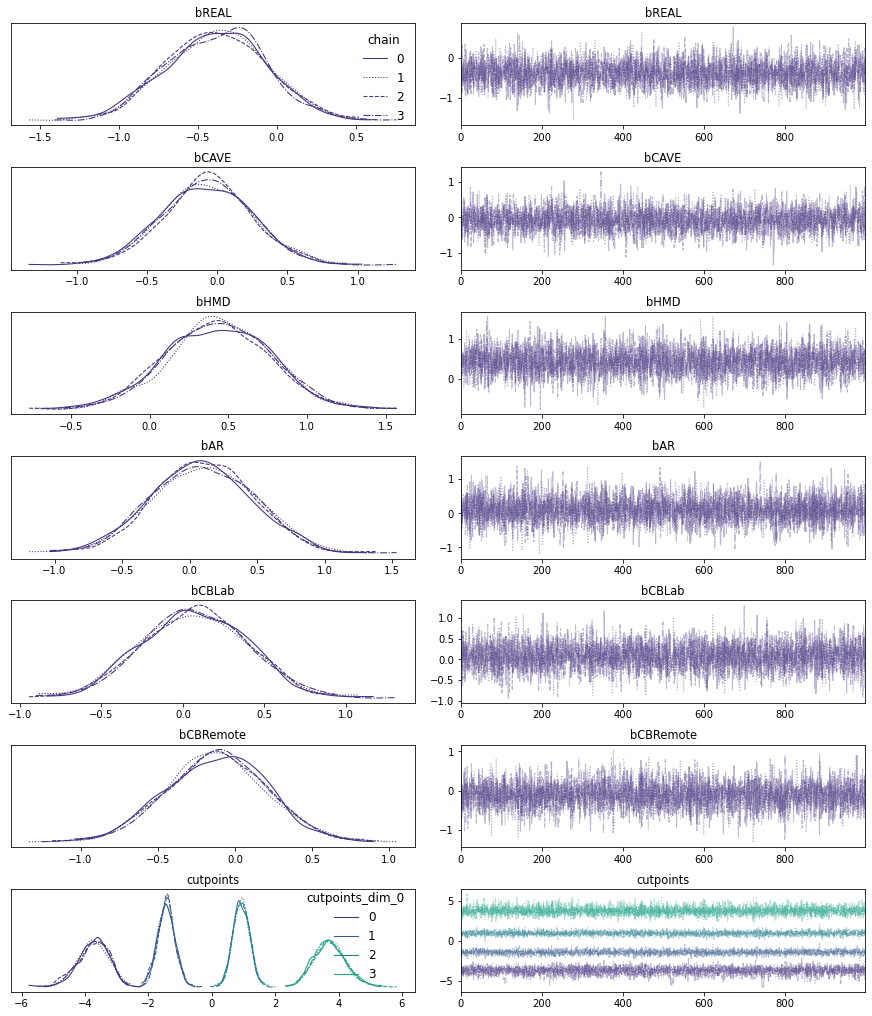

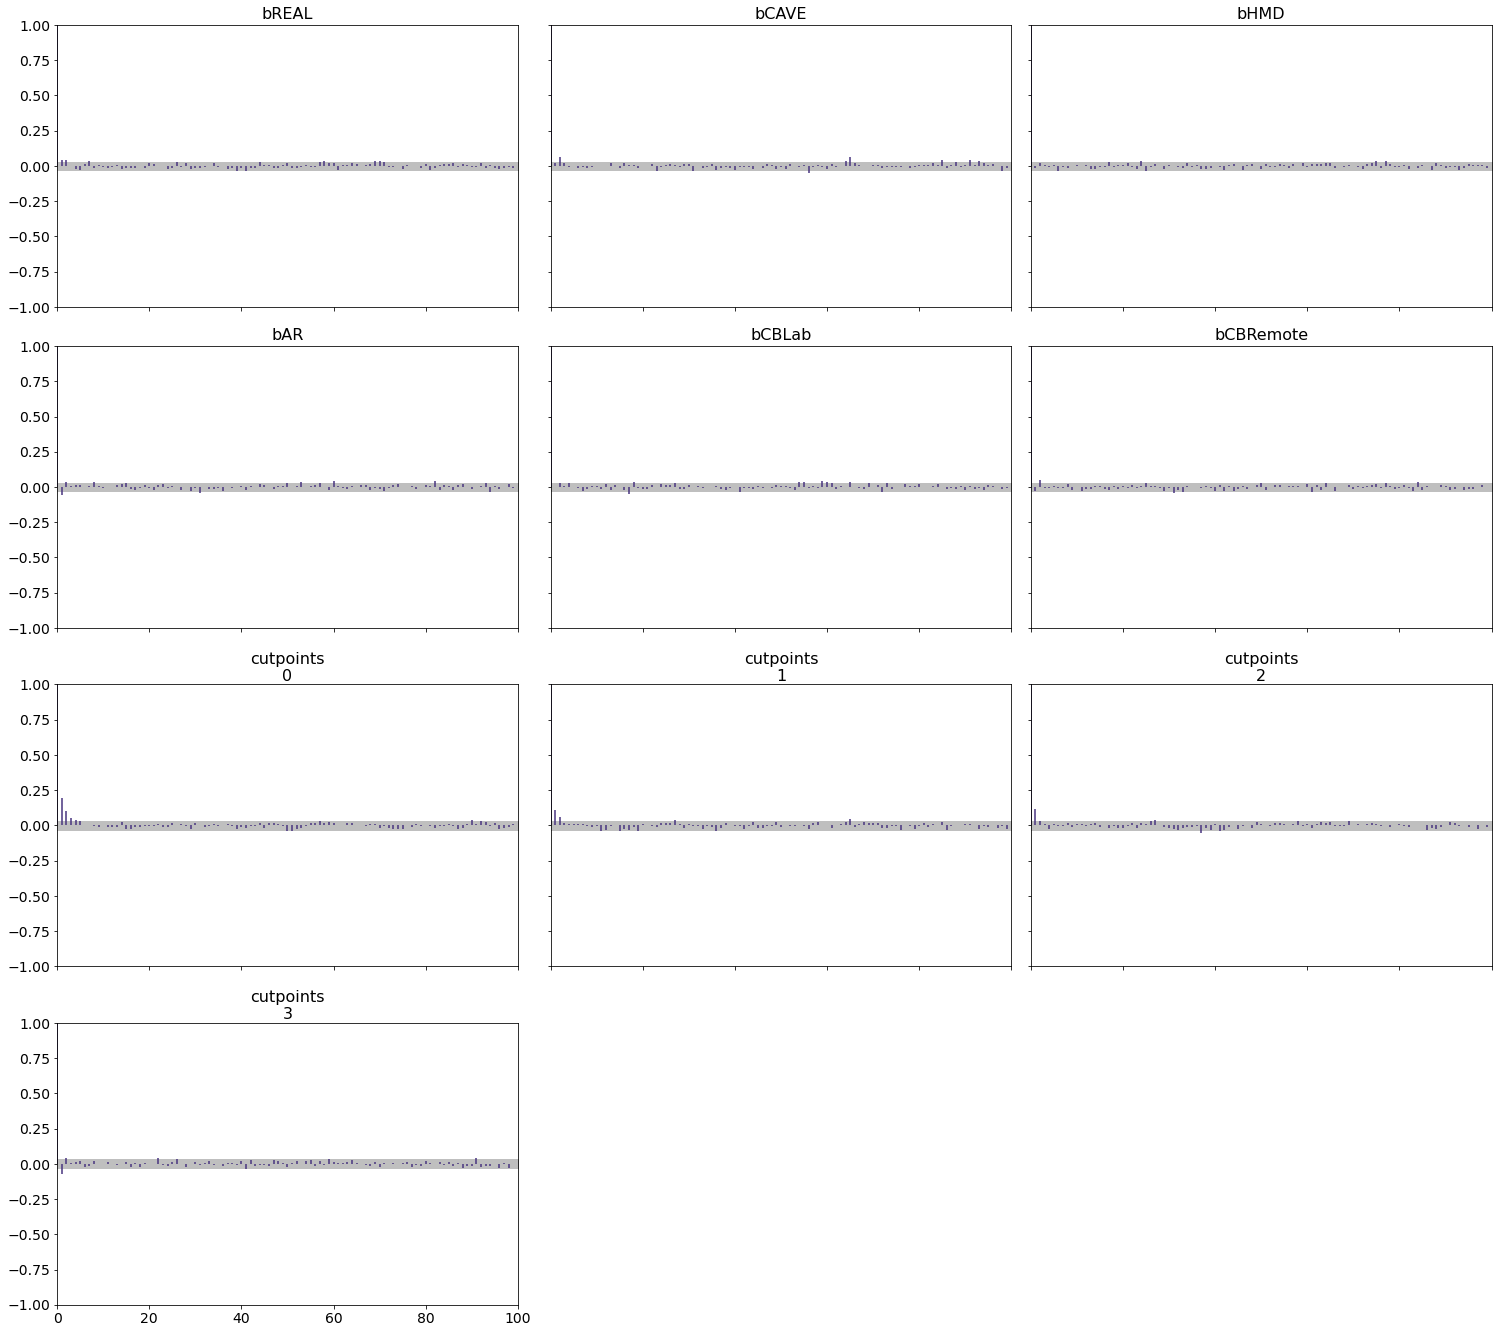

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


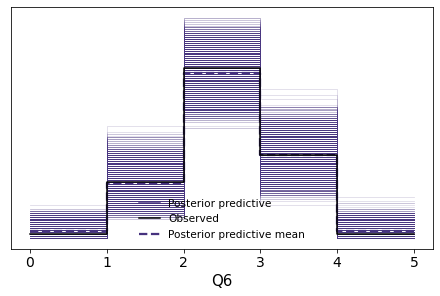

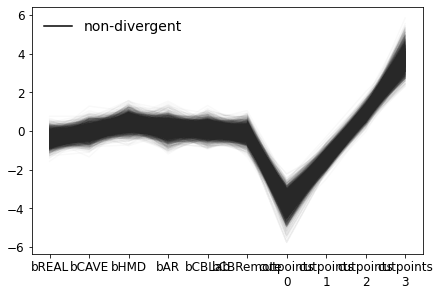

In [54]:
with Q6_model:
    ppc = pm.sample_posterior_predictive(trace_Q6, random_seed=RANDOM_SEED)

az.plot_trace(trace_Q6,var_names=["~eta"], filter_vars="regex",legend=True, compact=True);
az.plot_autocorr(trace_Q6,var_names=["~eta"], filter_vars="regex", combined = True);
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=Q6_model));
az.plot_parallel(trace_Q6,var_names=["~eta"], filter_vars="regex", legend = True);

### Compared to usual, deciding to cross the street was easy / difficult

In [55]:
#log-cumulative-odds cutpoints
lco = df_subjectives["Q7"].value_counts(normalize=True, sort=False).cumsum().apply(sp.special.logit)
lco.round(2)

 0.0    -0.98
 2.0    -0.42
-2.0    -0.35
 1.0     2.19
-1.0    36.74
Name: Q7, dtype: float64

In [56]:
#delete nan rows
nanIDX = np.argwhere(np.isnan(df_subjectives["Q7"].values))[0][0]
obs = np.delete(df_subjectives["Q7"].values, nanIDX)
dummies_ = dummies.drop([nanIDX])

In [57]:
with pm.Model() as Q7_model:
    cutpoints = pm.Normal(
        "cutpoints",
        0,
        1.5,
        transform=pm.distributions.transforms.ordered,
        shape=4,
        testval=np.arange(4),
    )
    bREAL = pm.Normal("bREAL", 0.0, 0.5)
    REAL = pm.Data("REAL", dummies_.REAL.values)
    
    bCAVE = pm.Normal("bCAVE", 0.0, 0.5)
    CAVE = pm.Data("CAVE", dummies_.CAVE.values)
    
    bHMD = pm.Normal("bHMD", 0.0, 0.5)
    HMD = pm.Data("HMD", dummies_.HMD.values)
    
    bAR = pm.Normal("bAR", 0.0, 0.5)
    AR = pm.Data("AR", dummies_.AR.values)
    
    bCBLab = pm.Normal("bCBLab", 0.0, 0.5)
    CBLab = pm.Data("CBLab", dummies_.CBLab.values)
    
    bCBRemote = pm.Normal("bCBRemote", 0.0, 0.5)
    CBRemote = pm.Data("CBRemote", dummies_.CBRemote.values)
    
    eta = pm.Deterministic("eta", bREAL * REAL + bCAVE * CAVE + bHMD * HMD + bAR * AR + bCBLab * CBLab + bCBRemote * CBRemote)

    Q7 = pm.OrderedLogistic("Q7", eta, cutpoints, observed = obs + 2)
    
    trace_Q7 = pm.sample(return_inferencedata=True, tune = 1000, random_seed=RANDOM_SEED)


REAL, CAVE, HMD, AR, CBLab, CBRemote = [trace_Q7.posterior[x].values for x in ['bREAL','bCAVE','bHMD','bAR','bCBLab','bCBRemote']]
Q7_diffs = [CAVE - REAL,HMD - REAL,AR - REAL,CBLab - REAL,CBRemote - REAL,CBRemote- CBLab]

az.summary(trace_Q7, round_to=2,var_names=["~eta"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bCBRemote, bCBLab, bAR, bHMD, bCAVE, bREAL, cutpoints]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 59 seconds.


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
bREAL        -0.25  0.31   -0.86     0.31       0.01     0.00   3281.66   
bCAVE        -0.41  0.33   -1.00     0.21       0.01     0.00   3207.81   
bHMD          0.04  0.32   -0.54     0.65       0.01     0.00   3738.07   
bAR           0.38  0.39   -0.41     1.08       0.01     0.01   4080.64   
bCBLab        0.41  0.33   -0.20     1.02       0.01     0.00   3430.16   
bCBRemote     0.31  0.33   -0.33     0.92       0.01     0.00   3189.81   
cutpoints[0] -3.71  0.50   -4.67    -2.81       0.01     0.01   2593.08   
cutpoints[1] -1.94  0.30   -2.49    -1.38       0.01     0.00   3122.07   
cutpoints[2] -0.39  0.26   -0.89     0.09       0.00     0.00   2861.88   
cutpoints[3]  2.04  0.30    1.46     2.59       0.01     0.00   3144.73   

              ess_tail  r_hat  
bREAL          3050.02    1.0  
bCAVE          2597.74    1.0  
bHMD           2818.41    1.0  
bAR            2645.57    1.0  
bCBLab         3031.84    1.0  
bCBRemote      2302.37    1.0  
cutpoints[0]   1749.43    1.0  
cutpoints[1]   2948.46    1.0  
cutpoints[2]   2742.87    1.0  
cutpoints[3]   2576.33    1.0

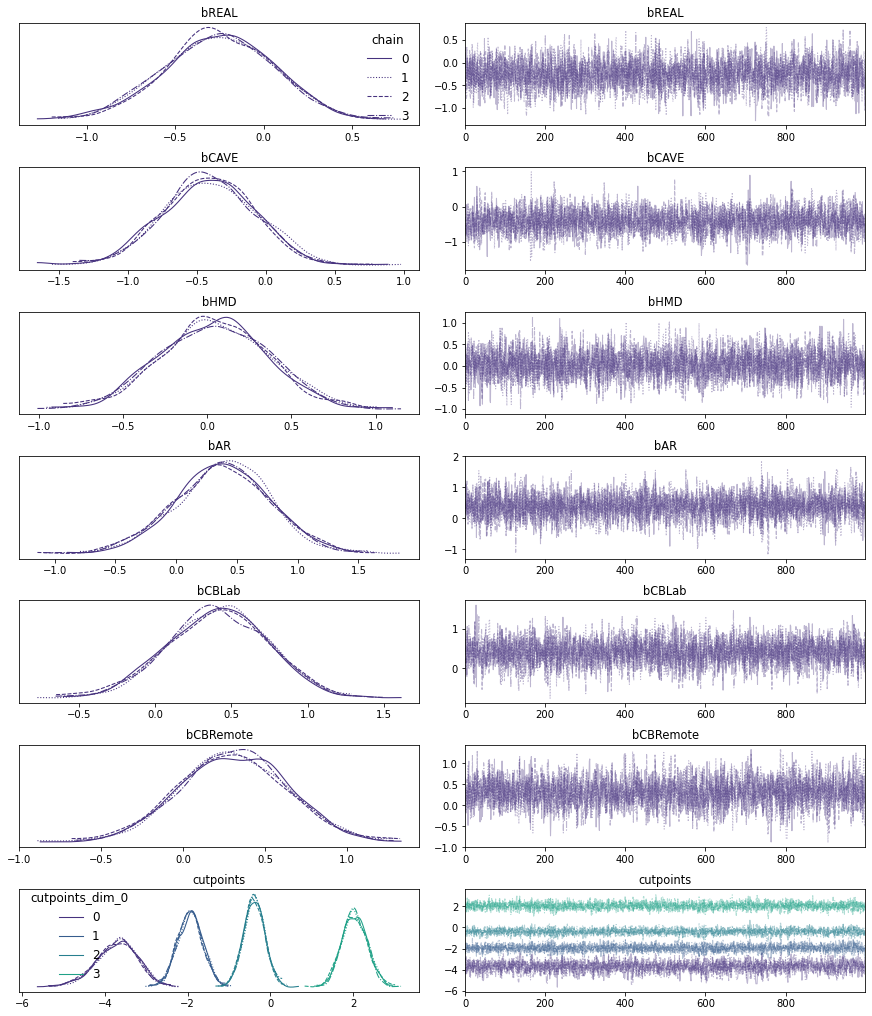

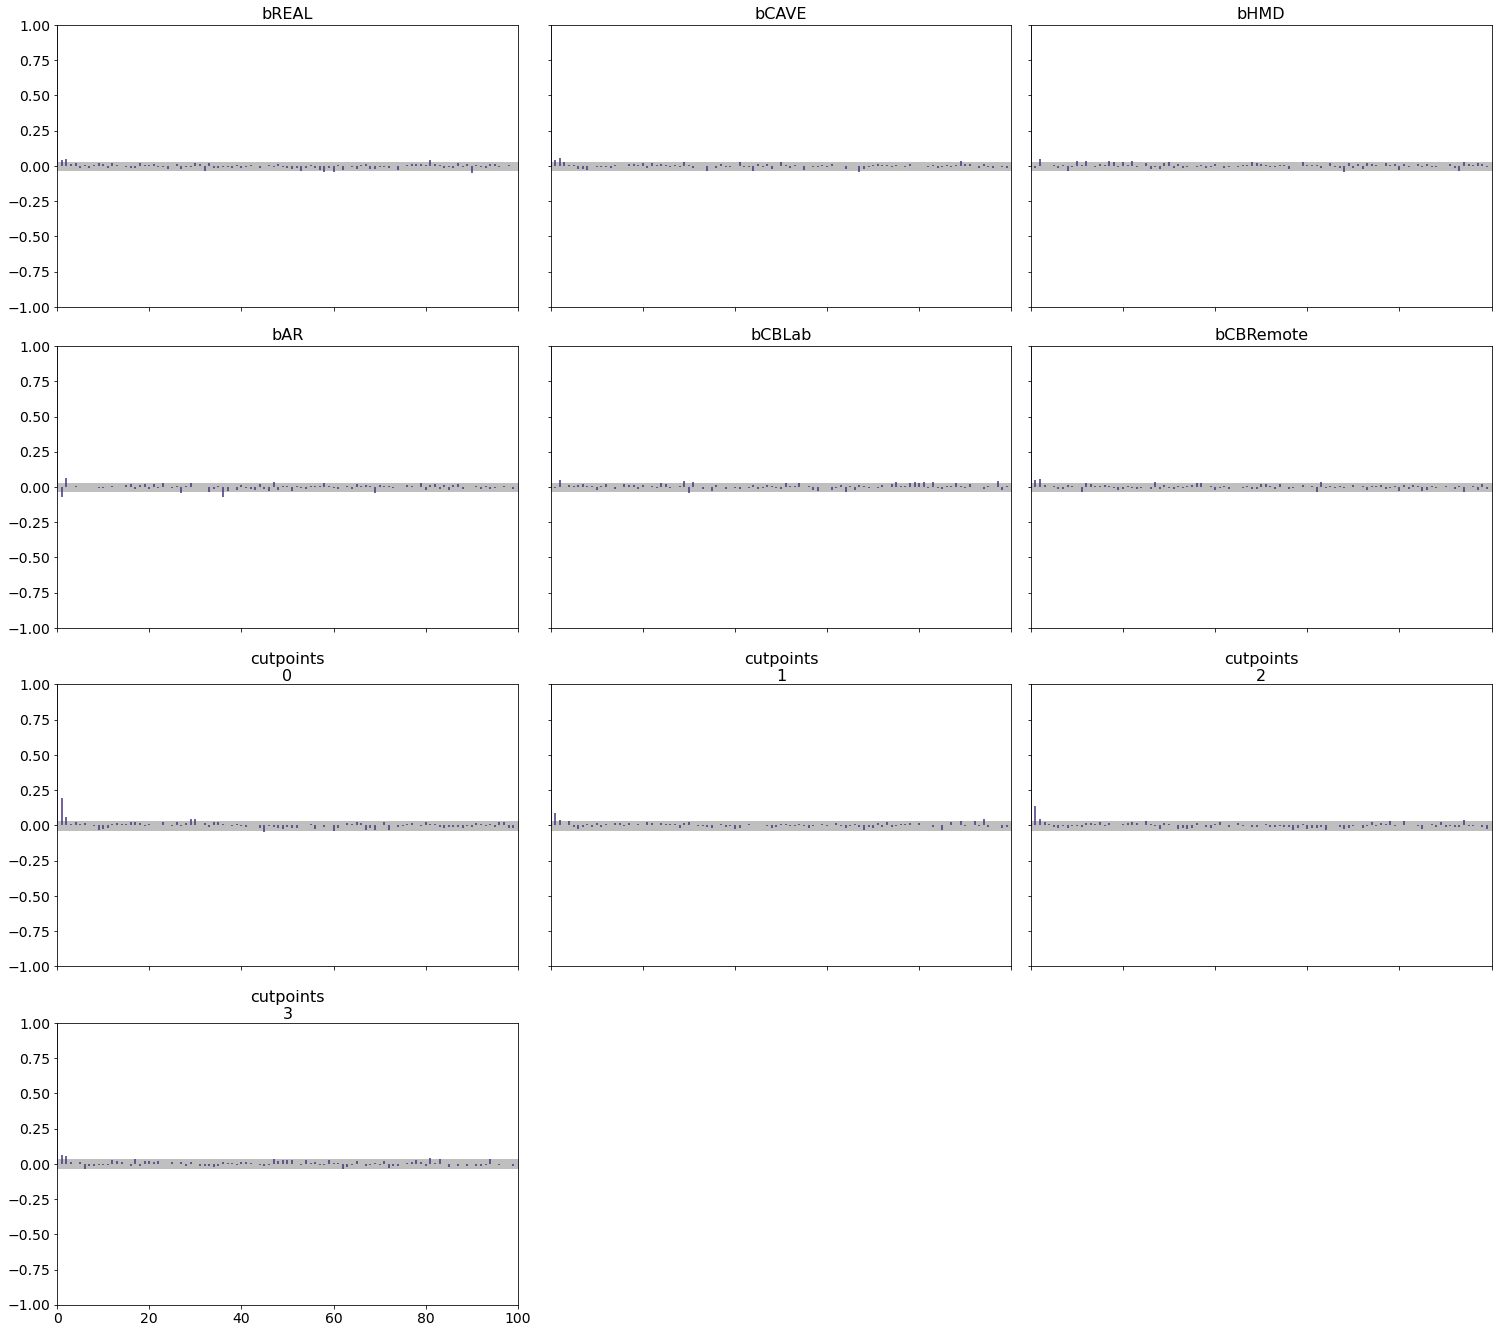

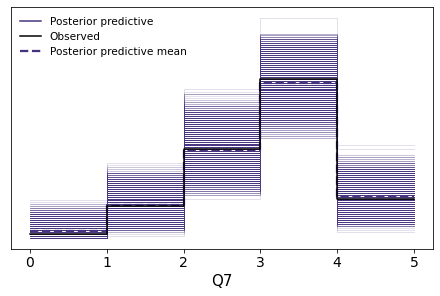

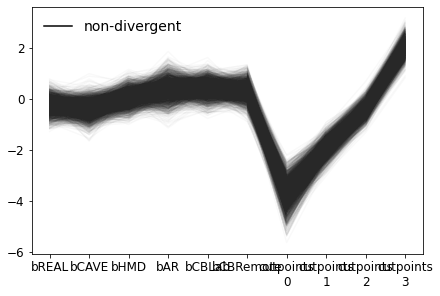

In [58]:
with Q7_model:
    ppc = pm.sample_posterior_predictive(trace_Q7, random_seed=RANDOM_SEED)

az.plot_trace(trace_Q7,var_names=["~eta"], filter_vars="regex",legend=True, compact=True);
az.plot_autocorr(trace_Q7,var_names=["~eta"], filter_vars="regex", combined = True);
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=Q7_model));
az.plot_parallel(trace_Q7,var_names=["~eta"], filter_vars="regex", legend = True);

### Compared to usual, making a decision took longer / shorter

In [59]:
#log-cumulative-odds cutpoints
lco = df_subjectives["Q8"].value_counts(normalize=True, sort=False).cumsum().apply(sp.special.logit)
lco.round(2)

 0.0   -0.55
 2.0   -0.47
-2.0   -0.27
 1.0    0.06
-1.0     inf
Name: Q8, dtype: float64

In [60]:
#delete nan rows
nanIDX = np.argwhere(np.isnan(df_subjectives["Q8"].values))[0][0]
obs = np.delete(df_subjectives["Q8"].values, nanIDX)
dummies_ = dummies.drop([nanIDX])

In [61]:
with pm.Model() as Q8_model:
    cutpoints = pm.Normal(
        "cutpoints",
        0,
        1.5,
        transform=pm.distributions.transforms.ordered,
        shape=4,
        testval=np.arange(4),
    )
    bREAL = pm.Normal("bREAL", 0.0, 0.5)
    REAL = pm.Data("REAL", dummies_.REAL.values)
    
    bCAVE = pm.Normal("bCAVE", 0.0, 0.5)
    CAVE = pm.Data("CAVE", dummies_.CAVE.values)
    
    bHMD = pm.Normal("bHMD", 0.0, 0.5)
    HMD = pm.Data("HMD", dummies_.HMD.values)
    
    bAR = pm.Normal("bAR", 0.0, 0.5)
    AR = pm.Data("AR", dummies_.AR.values)
    
    bCBLab = pm.Normal("bCBLab", 0.0, 0.5)
    CBLab = pm.Data("CBLab", dummies_.CBLab.values)
    
    bCBRemote = pm.Normal("bCBRemote", 0.0, 0.5)
    CBRemote = pm.Data("CBRemote", dummies_.CBRemote.values)
    
    eta = pm.Deterministic("eta", bREAL * REAL + bCAVE * CAVE + bHMD * HMD + bAR * AR + bCBLab * CBLab + bCBRemote * CBRemote)

    Q8 = pm.OrderedLogistic("Q8", eta, cutpoints, observed = obs + 2)
    
    trace_Q8 = pm.sample(return_inferencedata=True, tune = 1000, random_seed=RANDOM_SEED)


REAL, CAVE, HMD, AR, CBLab, CBRemote = [trace_Q8.posterior[x].values for x in ['bREAL','bCAVE','bHMD','bAR','bCBLab','bCBRemote']]
Q8_diffs = [CAVE - REAL,HMD - REAL,AR - REAL,CBLab - REAL,CBRemote - REAL,CBRemote- CBLab]

az.summary(trace_Q8, round_to=2,var_names=["~eta"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bCBRemote, bCBLab, bAR, bHMD, bCAVE, bREAL, cutpoints]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 51 seconds.


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
bREAL         0.10  0.32   -0.54     0.65       0.01     0.00   2922.65   
bCAVE         0.24  0.32   -0.33     0.87       0.01     0.00   3404.69   
bHMD         -0.58  0.33   -1.17     0.07       0.01     0.00   3284.67   
bAR          -0.23  0.37   -0.96     0.45       0.01     0.01   4451.15   
bCBLab        0.34  0.32   -0.25     0.95       0.01     0.00   3506.32   
bCBRemote    -0.19  0.32   -0.81     0.42       0.01     0.00   2968.62   
cutpoints[0] -3.03  0.39   -3.74    -2.30       0.01     0.01   2180.17   
cutpoints[1]  0.09  0.25   -0.37     0.56       0.01     0.00   2382.85   
cutpoints[2]  2.10  0.31    1.53     2.69       0.01     0.00   3110.08   
cutpoints[3]  3.70  0.50    2.75     4.64       0.01     0.01   4623.13   

              ess_tail  r_hat  
bREAL          2822.12    1.0  
bCAVE          2981.88    1.0  
bHMD           3066.05    1.0  
bAR            2782.62    1.0  
bCBLab         2726.83    1.0  
bCBRemote      2790.37    1.0  
cutpoints[0]   2317.89    1.0  
cutpoints[1]   2848.74    1.0  
cutpoints[2]   3358.79    1.0  
cutpoints[3]   2990.18    1.0

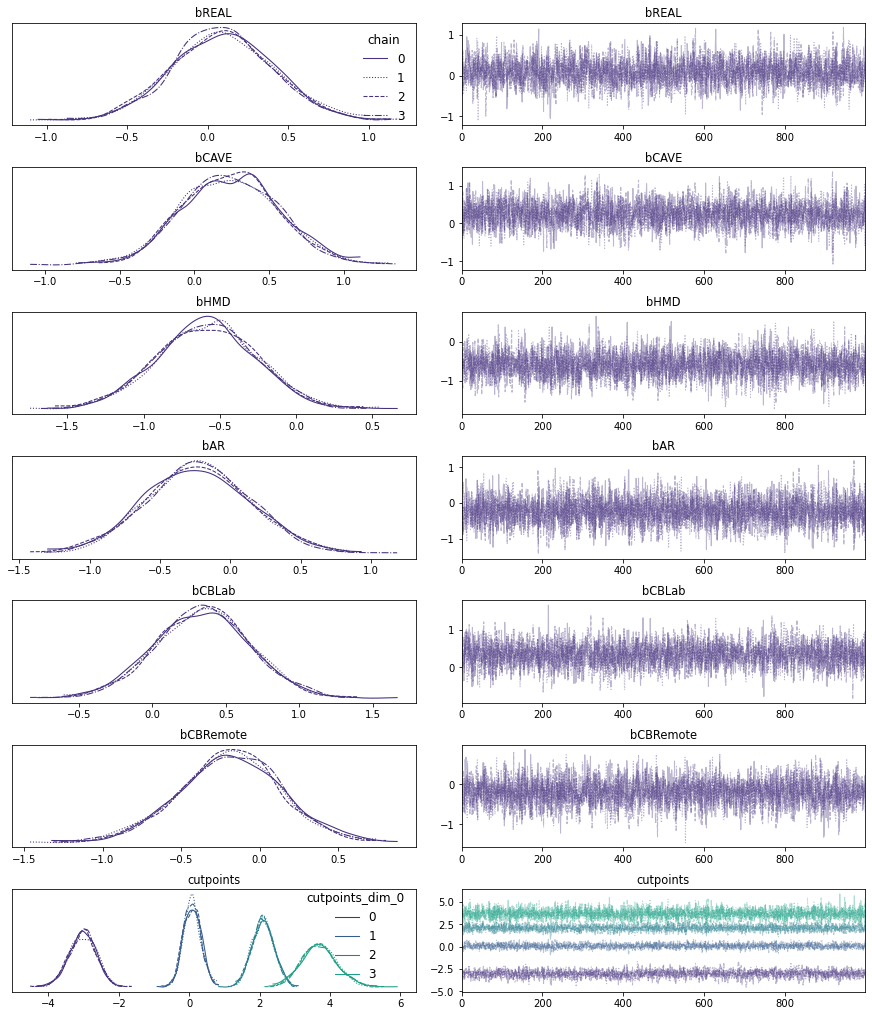

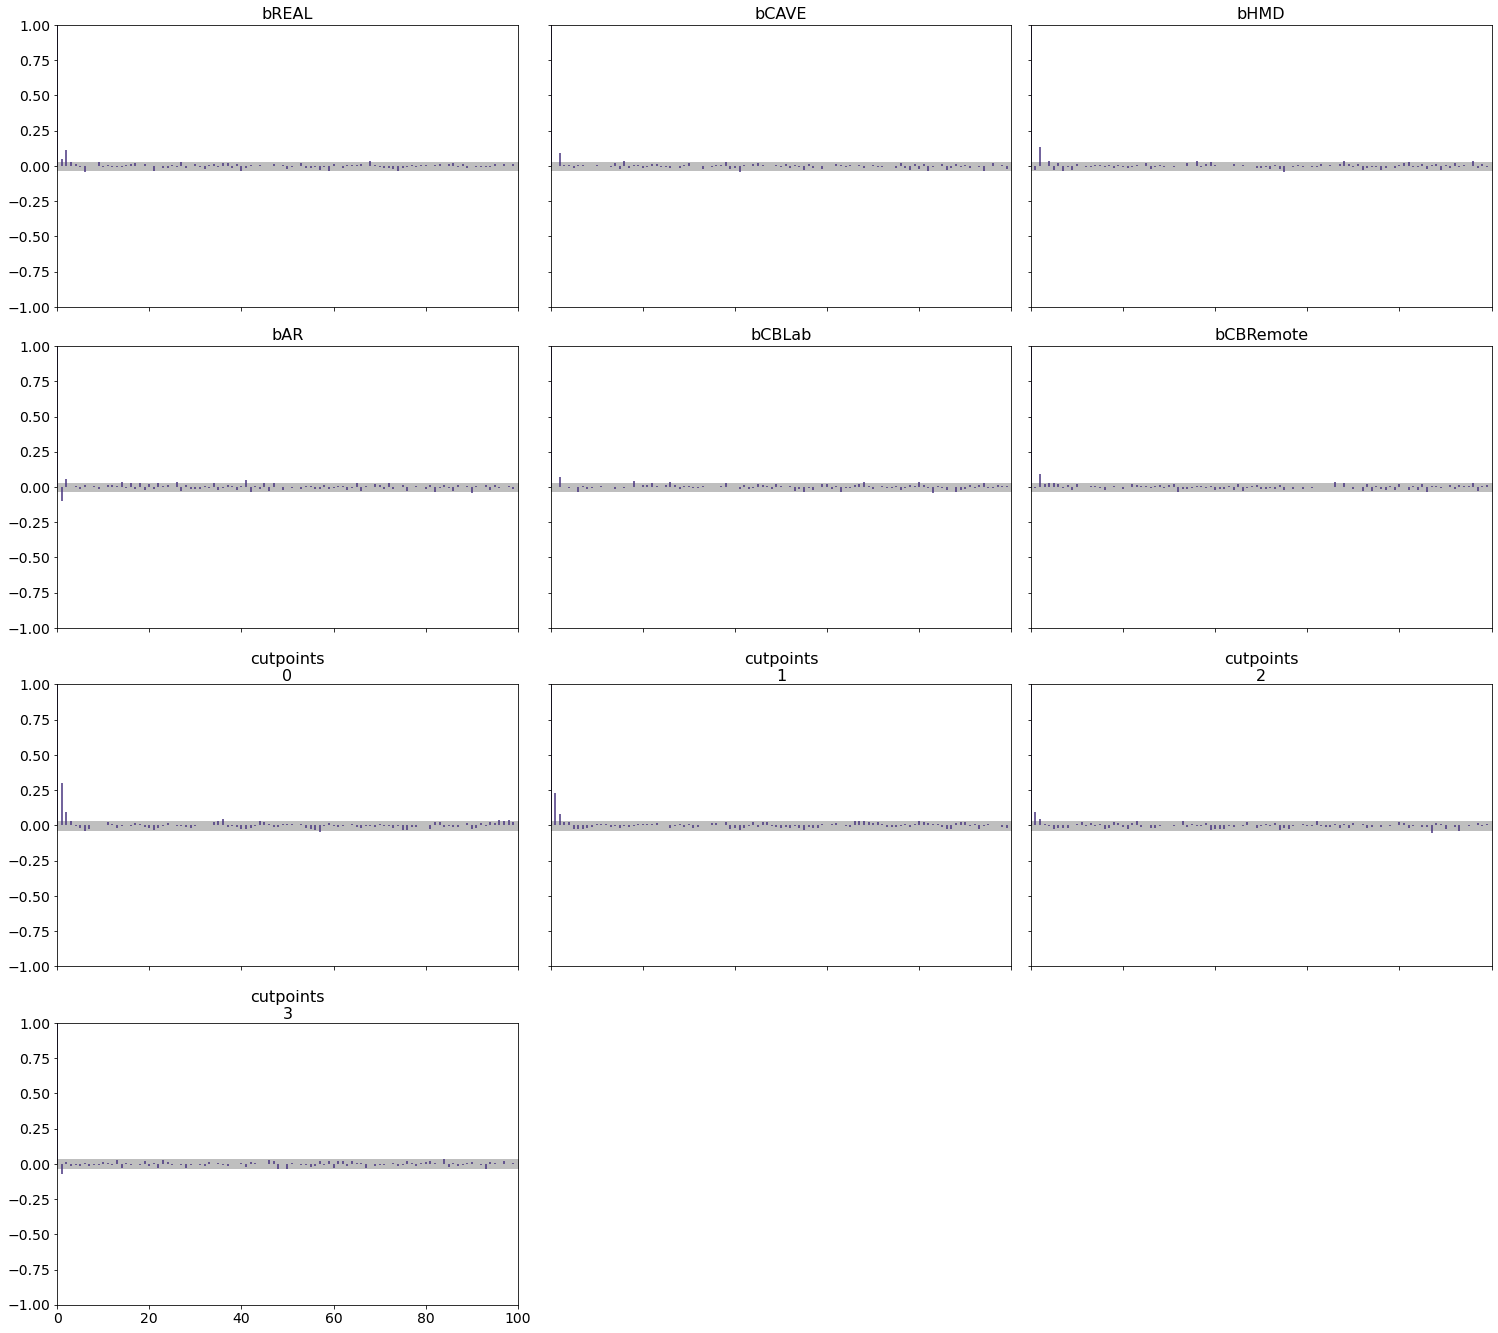

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


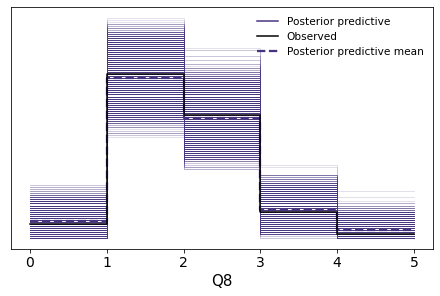

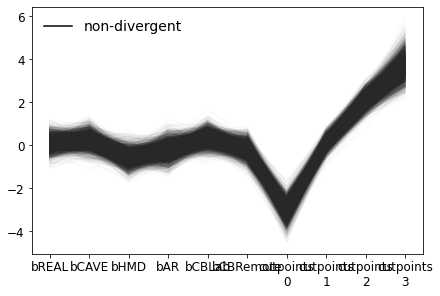

In [62]:
with Q8_model:
    ppc = pm.sample_posterior_predictive(trace_Q8, random_seed=RANDOM_SEED)

az.plot_trace(trace_Q8,var_names=["~eta"], filter_vars="regex",legend=True, compact=True);
az.plot_autocorr(trace_Q8,var_names=["~eta"], filter_vars="regex", combined = True);
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=Q8_model));
az.plot_parallel(trace_Q8,var_names=["~eta"], filter_vars="regex", legend = True);

### Summary

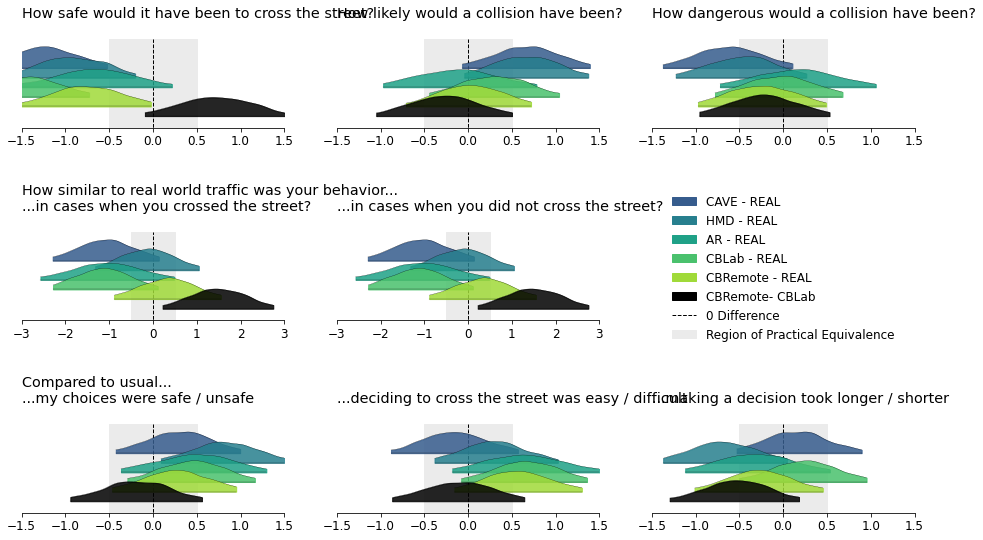

In [63]:
fig, axes = plt.subplots(3,3,figsize=(16, 9))
colors = sns.color_palette(palette = 'viridis')
colors.append('#000000')

def plotForest(data, ax):
    ax.vlines(0,-10,18,'black', 'dashed', zorder=-10,lw=1)
    az.plot_forest(data,
                   kind='ridgeplot',
                   model_names = ['Cave - Real','HMD - Real','AR - Real','CBLab - Real','CBRemote - Real','CBRemote - CBLab'],
                   combined=True,
                   ax = ax,
                   ridgeplot_overlap=5,
                   linewidth=0.25,
                   colors=colors,
                   ridgeplot_alpha=0.85)
    ax.spines['top'].set_color('white')
    ax.set_yticks([])

axes[0, 0].set_title("How safe would it have been to cross the street?" , loc='left')
axes[0, 0].add_patch(matplotlib.patches.Rectangle((-0.5,-10), 1, 28, zorder=-100,color="#ebebeb"))
plotForest(Q1_diffs, axes[0, 0])
axes[0, 0].set(xlim=(-1.5, 1.5))

axes[0, 1].set_title("How likely would a collision have been?" , loc='left')
axes[0, 1].add_patch(matplotlib.patches.Rectangle((-0.5,-10), 1, 28, zorder=-100,color="#ebebeb"))
plotForest(Q2_diffs, axes[0, 1])
axes[0, 1].set(xlim=(-1.5, 1.5))

axes[0, 2].set_title("How dangerous would a collision have been?" , loc='left')
axes[0, 2].add_patch(matplotlib.patches.Rectangle((-0.5,-10), 1, 28, zorder=-100,color="#ebebeb"))
plotForest(Q3_diffs, axes[0, 2])
axes[0, 2].set(xlim=(-1.5, 1.5))
    
axes[1, 0].set_title("How similar to real world traffic was your behavior... \n...in cases when you crossed the street?" , loc='left')
axes[1, 0].add_patch(matplotlib.patches.Rectangle((-0.5,-10), 1, 28, zorder=-100,color="#ebebeb"))
plotForest(Q4_diffs, axes[1, 0])
axes[1, 0].set(xlim=(-3, 3))

axes[1, 1].set_title("\n...in cases when you did not cross the street?" , loc='left')
axes[1, 1].add_patch(matplotlib.patches.Rectangle((-0.5,-10), 1, 28, zorder=-100,color="#ebebeb"))
plotForest(Q4_diffs, axes[1, 1])
axes[1, 1].set(xlim=(-3, 3))

axes[2, 0].set_title("Compared to usual... \n...my choices were safe / unsafe" , loc='left')
axes[2, 0].add_patch(matplotlib.patches.Rectangle((-0.5,-10), 1, 28, zorder=-100,color="#ebebeb"))
plotForest(Q6_diffs, axes[2, 0])
axes[2, 0].set(xlim=(-1.5, 1.5))

axes[2, 1].set_title("\n...deciding to cross the street was easy / difficult" , loc='left')
axes[2, 1].add_patch(matplotlib.patches.Rectangle((-0.5,-10), 1, 28, zorder=-100,color="#ebebeb"))
plotForest(Q7_diffs, axes[2, 1])
axes[2, 1].set(xlim=(-1.5, 1.5))

axes[2, 2].set_title("\n...making a decision took longer / shorter" , loc='left')
axes[2, 2].add_patch(matplotlib.patches.Rectangle((-0.5,-10), 1, 28, zorder=-100,color="#ebebeb"))
plotForest(Q8_diffs, axes[2, 2])
axes[2, 2].set(xlim=(-1.5, 1.5))



cave_patch = mpatches.Patch(color=colors[1], label='CAVE - REAL')
hmd_patch = mpatches.Patch(color=colors[2], label='HMD - REAL')
ar_patch = mpatches.Patch(color=colors[3], label='AR - REAL')
cblab_patch = mpatches.Patch(color=colors[4], label='CBLab - REAL')
cbremote_patch = mpatches.Patch(color=colors[5], label='CBRemote - REAL')
cbdiff_patch = mpatches.Patch(color=colors[6], label='CBRemote- CBLab')
line = Line2D([0], [0], color='black',ls='dashed', lw=1, label='0 Difference')

rope_patch = mpatches.Patch(color="#ebebeb", label='Region of Practical Equivalence')
axes[1, 2].legend(handles=[cave_patch,hmd_patch,ar_patch,cblab_patch,cbremote_patch,cbdiff_patch,line,rope_patch], loc='center')
axes[1, 2].axis('off')

fig.subplots_adjust(hspace=0.85, wspace=0.2)

In [64]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Tue May 11 2021

Python implementation: CPython
Python version       : 3.8.8
IPython version      : 7.22.0

pandas    : 1.2.4
bambi     : 0.4.1
numpy     : 1.19.2
matplotlib: 3.3.4
arviz     : 0.11.2
pymc3     : 3.11.2
scipy     : 1.6.2
seaborn   : 0.11.1

Watermark: 2.2.0

